In [ ]:
from typing import Optional

import matplotlib.pyplot as plt
import sys
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.semi_supervised import LabelPropagation, LabelSpreading, SelfTrainingClassifier
import warnings
from math import floor


from utils import *
from networks import * 
from trainer import *
from losses import *


# Load Data

In [ ]:

x = torch.load("/data/x_transactions.pt")
labels_orig = torch.load("/data/labels.pt")
emb_list = torch.load("/data/emb.pt")
x_logsig = torch.load("/data/x_logsig.pt")


'\nx = torch.load("/Users/davidhirnschall/Downloads/archive (1)/x.pt")\nlabels_orig = torch.load("/Users/davidhirnschall/Downloads/archive (1)/labels.pt")\nemb_list = torch.load("/Users/davidhirnschall/Downloads/archive (1)/emb.pt")\nx_logsig = torch.load("/Users/davidhirnschall/Downloads/archive (1)/x_logsig.pt")\n'

# Load model

In [ ]:
n_lags=20
import sys
from lib import augmentations
sys.modules['augmentations'] = augmentations

parent_directory = "/results"

items_r = []
random_state=[42, 54, 65, 71, 25]
x_real_rs, x_labelled_rs, x_fake_test_labelled_rs, x_labelled_sig_rs, x_fake_test_labelled_sig_rs, x_fake_test_labelled_sig_norm_rs, labels_rs, labels_test_rs, x_labelled_sig_norm, x_labelled_sig_norm_rs, acts_labelled_rs, acts_test_rs = [], [], [], [], [], [], [], [], [], [], [], []
D_rs, fn_rs, fn2_rs, D_post_rs, Ds_list_rs, G_rs = [], [], [], [], [], []
for r in random_state:
    parent_directory_r = os.path.join(parent_directory, str(r))
    items = [item for item in os.listdir(parent_directory_r) if item != '.DS_Store']
    items.sort(reverse=True)
    #items = [items[i] for i in [1,2, 0,4, 3]]
    
    items = [items[i] for i in [1,2,3,0,4,5]] 
    print(items)
    #items = [items[i] for i in [1,0]] 
    x_real, x_labelled, x_fake_test_labelled, x_labelled_sig, x_fake_test_labelled_sig, x_fake_test_labelled_sig_norm, labels, labels_test, acts_labelled, acts_test = [], [], [], [], [], [], [], [], [], []
    D, fn, fn2, D_post, Ds_list, G = [], [], [], [], [], []
    for i in range(len(items)):
        folder_name = items[i]
        #print(folder_name)
        experiment_dir = os.path.join(parent_directory_r, folder_name)
        data_config = load_obj( experiment_dir+'/data_config.pkl')
        discriminator_config = load_obj( experiment_dir+'/discriminator_config.pkl')
        generator_config = load_obj( experiment_dir+'/generator_config.pkl')
        gan_config = load_obj(experiment_dir+'/gan_config.pkl')

        with open(experiment_dir + '/x_real.pkl', 'rb') as f:
            x_real.append(pickle.load(f))
            
        with open(experiment_dir + '/generator_config.pkl', 'rb') as f:
            generator_config = pickle.load(f)
            
        generator_config.update(output_dim=x_real[i][0].shape[1])
        generator_config.update(output_dim=[140,3])
        generator_config.update(hidden_dims=[256,256])
        generator_config.update(input_dim=271) 
        G.append(get_generator(**generator_config))
        D.append(get_discriminator(**discriminator_config))
        G[-1].load_state_dict(load_obj(experiment_dir + '/generator_0_state_dict.pt'))
        G[-1].eval()
        D[-1].load_state_dict(torch.load(experiment_dir + '/discriminator_state_max_wauc.pth', map_location=torch.device('cpu'))[0])#    /discriminator_0_state_dict.pt'))
        D[-1].eval()
        discriminator_config.update(output_dim=2)
        fn.append(get_discriminator(**discriminator_config))
        fn[-1].load_state_dict(load_obj(experiment_dir + '/fullsup_discriminator__state_dict.pt'))
        
        with open(experiment_dir + '/x_labelled_sig.pkl', 'rb') as f:
            x_labelled_sig.append(torch.tensor(pickle.load(f)))
    
        with open(experiment_dir + '/x_fake_test_labelled_sig.pkl', 'rb') as f:
            x_fake_test_labelled_sig.append(torch.tensor(pickle.load(f)))

        with open(experiment_dir + '/labels.pkl', 'rb') as f:
            labels.append(torch.tensor(pickle.load(f)))

        with open(experiment_dir + '/labels_test.pkl', 'rb') as f:
            labels_test.append(torch.tensor(pickle.load(f)))
            
        with open(experiment_dir + '/acts_labelled.pkl', 'rb') as f:
            acts_labelled.append(pickle.load(f))
            
        with open(experiment_dir + '/acts_test.pkl', 'rb') as f:
            acts_test.append(pickle.load(f))
            
        discriminator_config.update(output_dim=3)
        D_post.append(torch.load(experiment_dir + '/discriminator_posterior_state_dict.pth', map_location=torch.device('cpu')))
        Ds = []
        for i in range(len(D_post[-1])):
            Ds.append(get_discriminator(**discriminator_config))
            Ds[-1].load_state_dict(D_post[-1][i][0])
            Ds[-1].eval()
        Ds_list.append(Ds)
        
    acts_labelled_rs.append(acts_labelled)
    acts_test_rs.append(acts_test)
    x_real_rs.append(x_real)
    x_labelled_rs.append(x_labelled)
    x_fake_test_labelled_rs.append(x_fake_test_labelled)
    x_labelled_sig_rs.append(x_labelled_sig)
    x_fake_test_labelled_sig_rs.append(x_fake_test_labelled_sig)
    labels_rs.append(labels)
    labels_test_rs.append(labels_test)
    items_r.append(items)
    D_post_rs.append(D_post)
    Ds_list_rs.append(Ds_list)

    D_rs.append(D)
    fn_rs.append(fn)

    G_rs.append(G)


['SBGAN_ResFNN_gen_ResFNN_0_1G1D_7_False_True_0.999_G0.0001_D0.005_42_2048_10', 'SBGAN_ResFNN_gen_ResFNN_0_1G1D_7_False_True_0.995_G0.0001_D0.005_42_2048_10', 'SBGAN_ResFNN_gen_ResFNN_0_1G1D_7_False_True_0.9925_G0.0001_D0.005_42_2048_10', 'SBGAN_ResFNN_gen_ResFNN_0_1G1D_7_False_True_0.99_G0.0001_D0.005_42_2048_10', 'SBGAN_ResFNN_gen_ResFNN_0_1G1D_7_False_True_0.975_G0.0001_D0.005_42_2048_10', 'SBGAN_ResFNN_gen_ResFNN_0_1G1D_7_False_True_0.95_G0.0001_D0.005_42_2048_10']
{'LSTM': <class 'lib.Networks.generators.LSTMGenerator'>, 'LogSigRNN': <class 'lib.Networks.generators.LogSigRNNGenerator'>, 'ResFNN_gen': <class 'lib.Networks.generators.ResFNNGenerator'>}
{'LSTM': <class 'lib.Networks.generators.LSTMGenerator'>, 'LogSigRNN': <class 'lib.Networks.generators.LogSigRNNGenerator'>, 'ResFNN_gen': <class 'lib.Networks.generators.ResFNNGenerator'>}
{'LSTM': <class 'lib.Networks.generators.LSTMGenerator'>, 'LogSigRNN': <class 'lib.Networks.generators.LogSigRNNGenerator'>, 'ResFNN_gen': <class 

# Compare with Baseline

In [ ]:
# use frauds to seperate groups
start_ind = 5
df = data.copy()

from sklearn.preprocessing import LabelEncoder
# Convert columns to appropriate types
df['age'] = df['age'].str.strip("'").astype(int)
df['step'] = df['step'].astype(int)
df['amount'] = df['amount'].astype(float)

# Encode categorical columns
categorical_cols = ['gender', 'category', 'risk_level', 'customer', 'zipcodeOri', 'zipMerchant', 'merchant']
le=[]
for col in categorical_cols:
    le.append(LabelEncoder())
    df[col] = le[-1].fit_transform(df[col])
    
# Drop unnecessary columns
#df = df.drop(columns=['zipcodeOri', 'zipMerchant', 'merchant'])
cs = df.groupby('customer')['fraud'].cumsum()

filtered_data = (
    df
    .groupby("customer", group_keys=False)
    .apply(lambda group: group.iloc[(start_ind-1):])     #(start_ind-1):-1 damit es mit trainingsdaten übereinstimmt
    .reset_index(drop=True)
)
filtered_labels = torch.tensor(filtered_data["fraud"])

indices_train, indices_test = train_test_list(filtered_labels, 0.1, random_state=42)
train, test = filtered_data.iloc[indices_train, :], filtered_data.iloc[indices_test, :]

indices_train, indices_test = train_test_list(torch.stack(labels_orig).to(int), 0.1, random_state=42)
x_train_all, y_train_all, acts_train_all = [x[i] for i in indices_train], torch.stack([labels_orig[i] for i in indices_train]), torch.stack(emb_list)[indices_train,:]

aug = [Scale(scale=2, dim=0),
     AddTime(),
     LeadLag(with_time=False),
     VisiTrans(type='I')]
#x_real_logsig = sig_list(x_train_all, aug)
x_real_logsig = torch.stack([x_logsig[i] for i in indices_train])

x_train_all_rf = torch.cat((x_real_logsig, acts_train_all), dim=1)

'indices_labeled, _ = train_test_list(torch.tensor(train["fraud"].values), rates[i], random_state=42)\nlabeled = train.iloc[indices_labeled,:]\n\nx_train, y_train = train.iloc[:,[0,1,2,3,7,8]], train.iloc[:,9]\nx_test, y_test = test.iloc[:,[0,1,2,3,7,8]], test.iloc[:,9]\n\nx_labeled, y_labeled = labeled.iloc[:,[0,1,2,3,7,8]], labeled.iloc[:,9]'

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.semi_supervised import LabelPropagation, LabelSpreading, SelfTrainingClassifier
import warnings
from math import floor
warnings.filterwarnings('ignore')
torch.manual_seed(0)
np.random.seed(0) 

#rates = np.array([0.99, 0.95, 0.9, 0.85, 0.8])#, 0.25, 0.2])
rates = np.array([0.999, 0.995, 0.9925, 0.99, 0.975, 0.95])
wauc_rf_rs, wauc_rf_semisup_rs, wauc_kn_rs, wauc_lp_rs, wauc_rf_direct_rs, wauc_rf_semisup_direct_rs, wauc_kn_direct_rs, wauc_fn_rs, wauc_fn2_rs, wauc_gan_rs, wauc_gan2_rs, wauc_ssl_rs, wauc_ssl2_rs, wauc_svm_rs, wauc_nb_rs =[],[],[],[],[], [],[],[],[],[], [], [], [], [], []
results_rs, mf1_rs, misclass_df_rs, cross_entropy_df_rs, wauc_df_rs, pr_auc_df_rs, rauc_df_rs, brier_df_rs =[],[], [], [], [], [], [], []
gg_prob_rs = []
sum_good = []
preK_rf_rs, preK_gan_rs, preK_kn_rs, preK_l_rs, preK_l_ssl_rs, preK_svm_rs, preK_m_rs, preK_rf2_rs, preK_fn_rs, preK_gan_p_rs, preK_nb_rs, preK_mt_rs = [], [], [], [], [], [], [], [], [], [], [], []
costK_rf_rs, costK_gan_rs, costK_kn_rs, costK_l_rs, costK_l_ssl_rs, costK_svm_rs, costK_m_rs, costK_rf2_rs, costK_fn_rs, costK_gan_p_rs, costK_nb_rs, costK_mt_rs = [], [], [], [], [], [], [], [], [], [], [], []
praucK_rf_rs, praucK_gan_rs, praucK_kn_rs, praucK_l_rs, praucK_l_ssl_rs, praucK_svm_rs, praucK_m_rs, praucK_rf2_rs, praucK_fn_rs, praucK_gan_p_rs, praucK_nb_rs, praucK_mt_rs = [], [], [], [], [], [], [], [], [], [], [], []

indices_train, indices_test = train_test_list(torch.stack(labels_orig).to(int), 0.1, random_state=42)

#for orig data
indices_train, indices_test = train_test_list(filtered_labels, 0.1, random_state=42)

print(len(indices_test))
labels_orig_first_fraud = torch.stack([labels_orig[i].to(int) for i in indices_train])

indxx = [i for i, xi in enumerate(x) if xi.shape[0] > 0]
common_indices = list(set(indices_test).intersection(indxx))  #[i for i in indices_train if i in set(indxx)]

# scale amount
#train.iloc[:,[8]] = train.iloc[:,[8]] / train.iloc[:,[8]].max()
#filtered_data.iloc[:,[8]] = filtered_data.iloc[:,[8]] / train.iloc[:,[8]].max()

for rand in range(len(random_state)):
    wauc_rf, wauc_rf_semisup, wauc_kn, wauc_lp, wauc_rf_direct, wauc_rf_semisup_direct, wauc_kn_direct, wauc_fn, wauc_fn2, wauc_gan, wauc_gan2, wauc_ssl, wauc_ssl2, wauc_rf_norm, wauc_kn_norm, wauc_m, wauc_gan_p, wauc_l, wauc_svm , wauc_nb, wauc_rf2, wauc_rf3, wauc_l_ssl, wauc_svm_ssl, wauc_kn_ssl, wauc_svm_aug, wauc_l_aug, wauc_kn_aug, wauc_nb_ssl, wauc_m_ssl, wauc_mt =[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[], [],[],[],[],[], [], [], [], [], [], [], [], [], [], []
    names = ["Size","N_l", 'RF', 'KN', 'LReg', 'LReg SSL', 'SVM', 'NB', 'FN', 'GAN', 'GAN_p']
    
    results = pd.DataFrame(columns=names) 
    mf1 = pd.DataFrame(columns=names) 
    misclass_df = pd.DataFrame(columns=names)
    cross_entropy_df = pd.DataFrame(columns=names)
    pr_auc_df = pd.DataFrame(columns=names)
    rauc_df = pd.DataFrame(columns=names)
    brier_df = pd.DataFrame(columns=names) 
    
    pr_auc_mean_teacher = []
    
    n_l = []
    k_list=[0.1, 0.2, 0.5, 1.0]
    pre_cols = [f"Prec@{k}" for k in k_list] + [f"Recall@{k}" for k in k_list]
    cost_cols = k_list
    prauc_cols = [0.5, 0.6, 0.7, 0.8]

    preK_rf     = pd.DataFrame(columns=pre_cols)
    preK_gan    = pd.DataFrame(columns=pre_cols)
    preK_kn     = pd.DataFrame(columns=pre_cols)
    preK_l      = pd.DataFrame(columns=pre_cols)
    preK_l_ssl  = pd.DataFrame(columns=pre_cols)
    preK_svm    = pd.DataFrame(columns=pre_cols)
    preK_m      = pd.DataFrame(columns=pre_cols)
    preK_rf2    = pd.DataFrame(columns=pre_cols)
    preK_fn     = pd.DataFrame(columns=pre_cols)
    preK_gan_p  = pd.DataFrame(columns=pre_cols)
    preK_nb     = pd.DataFrame(columns=pre_cols)
    preK_mt     = pd.DataFrame(columns=pre_cols)

    # CostK DataFrames
    costK_rf     = pd.DataFrame(columns=cost_cols)
    costK_gan    = pd.DataFrame(columns=cost_cols)
    costK_kn     = pd.DataFrame(columns=cost_cols)
    costK_l      = pd.DataFrame(columns=cost_cols)
    costK_l_ssl  = pd.DataFrame(columns=cost_cols)
    costK_svm    = pd.DataFrame(columns=cost_cols)
    costK_m      = pd.DataFrame(columns=cost_cols)
    costK_rf2    = pd.DataFrame(columns=cost_cols)
    costK_fn     = pd.DataFrame(columns=cost_cols)
    costK_gan_p  = pd.DataFrame(columns=cost_cols)
    costK_nb     = pd.DataFrame(columns=cost_cols)
    costK_mt     = pd.DataFrame(columns=cost_cols)
    
    praucK_rf     = pd.DataFrame(columns=prauc_cols)
    praucK_gan    = pd.DataFrame(columns=prauc_cols)
    praucK_kn     = pd.DataFrame(columns=prauc_cols)     
    praucK_l      = pd.DataFrame(columns=prauc_cols)
    praucK_l_ssl  = pd.DataFrame(columns=prauc_cols)
    praucK_svm    = pd.DataFrame(columns=prauc_cols)
    praucK_m      = pd.DataFrame(columns=prauc_cols)
    praucK_rf2    = pd.DataFrame(columns=prauc_cols)
    praucK_fn     = pd.DataFrame(columns=prauc_cols)
    praucK_gan_p  = pd.DataFrame(columns=prauc_cols)
    praucK_nb     = pd.DataFrame(columns=prauc_cols)
    praucK_mt     = pd.DataFrame(columns=prauc_cols)
    
    for i in range(len(x_real)):

        torch.manual_seed(0)
        np.random.seed(0)  
        X_train, y_train = x_labelled_sig_rs[rand][i].numpy(), labels_rs[rand][i]#.numpy()
        X_val, y_val = x_fake_test_labelled_sig_rs[rand][i].numpy(), labels_test_rs[rand][i].numpy()
        
        acts_labelled, acts_test = torch.tensor(acts_labelled_rs[rand][i]), torch.tensor(acts_test_rs[rand][i])
        
        X_train_rf = torch.cat((torch.tensor(X_train), acts_labelled), dim=1).numpy()
        print(X_train_rf.shape)
        X_val_rf = torch.cat((torch.tensor(X_val), acts_test), dim=1).numpy()
        
        X_val, y_val, acts_test = x_logsig[common_indices,: ], torch.stack(labels_orig).to(int)[common_indices].numpy(), torch.stack(emb_list)[common_indices,: ]
        X_val_rf = torch.cat((torch.tensor(X_val), acts_test), dim=1).numpy()
        
        #####################
        # prepare orig data for single transaction features
        """indices_labeled, _ = train_test_list(torch.tensor(train["fraud"].values), rates[i], random_state=random_state[rand])
        labeled = train.iloc[indices_labeled,:]
        x_train, y_train = train.iloc[:,[0,1,2,3,5,7,8]], train.iloc[:,9]
        x_test, y_test = test.iloc[:,[0,1,2,3,5,7,8]], test.iloc[:,9]
        x_labeled, y_labeled = labeled.iloc[:,[0,1,2,3,5,7,8]], labeled.iloc[:,9]
        X_train_rf, X_val_rf = x_labeled, x_test
        y_train, y_val = y_labeled.values, y_test.values
        
        X_val_rf, y_val = filtered_data.iloc[common_indices,[0,1,2,3,5,7,8]].values, torch.stack(labels_orig).to(int)[common_indices].cpu().numpy()
        y_train_all = torch.tensor(train.iloc[:,9].values)
        x_train_all_rf = torch.tensor(x_train.values)"""
        ######################
        
        indices_labeled, indices_unlabeled = train_test_list(torch.tensor(y_train_all).to(int), rates[i], random_state=rand)
        x_unlabelled, acts_unlabelled = x_train_all_rf[indices_unlabeled,:], acts_train_all[indices_unlabeled,:]
        
        y_train_masked = y_train_all.to(int).clone()
        y_train_masked[indices_unlabeled] = -1
        
           
        n_l.append(X_train.shape[0])
        
        tmp = [1-rates[i], X_train.shape[0]]
        mf1_tmp = [1-rates[i], X_train.shape[0]]
        misclass = [1-rates[i], X_train.shape[0]]
        pr_auc = [1-rates[i], X_train.shape[0]]
        rauc = [1-rates[i], X_train.shape[0]]
        
        rf = RandomForestClassifier(n_estimators=100, class_weight='balanced')
        rf.fit(X_train_rf, y_train)
        rf_prob = rf.predict_proba(X_val_rf)
        
        tmp.append(f1_score(y_val, np.argmax(rf_prob, axis=1)))
        mf1_tmp.append(f1_score(y_val, np.argmax(rf_prob, axis=1), average="macro"))
        misclass.append( (np.array(y_val) != np.argmax(rf_prob, axis=1)).sum() / y_val.shape[0])
        precision, recall, _ = precision_recall_curve(np.array(y_val), np.array(rf_prob[:, 1]))
        pr_auc.append(auc(recall, precision))
        if y_val.sum()==y_val.shape[0] or y_val.sum()==0:
            rauc.append(0)
        else:
            rauc.append(roc_auc_score(np.array(y_val), np.array(rf_prob[:,1])))
            
        
        #print("kn")
        kn = KNeighborsClassifier(n_neighbors=2)
        kn.fit(X_train_rf, y_train)
        kn_prob = kn.predict_proba(X_val_rf)
        tmp.append(f1_score(y_val, np.argmax(kn_prob, axis=1)))#, average="weighted"))
        mf1_tmp.append(f1_score(y_val, np.argmax(kn_prob, axis=1), average="macro"))
        misclass.append( (np.array(y_val) != np.argmax(kn_prob, axis=1)).sum() / y_val.shape[0])  
        precision, recall, _ = precision_recall_curve(np.array(y_val), np.array(kn_prob[:,1]))
        pr_auc.append(auc(recall, precision))
        if y_val.sum()==y_val.shape[0] or y_val.sum()==0:
            rauc.append(0)
        else:
            rauc.append(roc_auc_score(np.array(y_val), np.array(kn_prob[:,1])))
        
        
        #print("lr")
        l = LogisticRegression()
        l.fit(X_train_rf, y_train)
        l_prob = l.predict_proba(X_val_rf)
        #print(wauc(y_val[:,0].to(int), m_prob, classes=[0,1]))
        tmp.append(f1_score(y_val, np.argmax(l_prob, axis=1)))#, average="weighted"))
        mf1_tmp.append(f1_score(y_val, np.argmax(l_prob, axis=1), average="macro"))
        misclass.append( (np.array(y_val) != np.argmax(l_prob, axis=1)).sum() / y_val.shape[0])
        precision, recall, _ = precision_recall_curve(np.array(y_val), np.array(l_prob[:,1]))
        pr_auc.append(auc(recall, precision))
        if y_val.sum()==y_val.shape[0] or y_val.sum()==0:
            rauc.append(0)
        else:
            rauc.append(roc_auc_score(np.array(y_val), np.array(l_prob[:,1])))
            
        #print("lr ssl")
        base_model = LogisticRegression()
        l_ssl = SelfTrainingClassifier(base_model, threshold=0.75)
        l_ssl.fit(x_train_all_rf, y_train_masked)
        l_ssl_prob = l_ssl.predict_proba(X_val_rf)
        tmp.append(f1_score(y_val, np.argmax(l_ssl_prob, axis=1)))#, average="weighted"))
        mf1_tmp.append(f1_score(y_val, np.argmax(l_ssl_prob, axis=1), average="macro"))
        misclass.append( (np.array(y_val) != np.argmax(l_ssl_prob, axis=1)).sum() / y_val.shape[0])
        precision, recall, _ = precision_recall_curve(np.array(y_val), np.array(l_ssl_prob[:,1]))
        pr_auc.append(auc(recall, precision))
        rauc.append(roc_auc_score(np.array(y_val), np.array(l_ssl_prob[:,1])))
        
        #print("svm")
        svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
        svm_model.fit(X_train_rf, y_train)
        svm_prob = svm_model.predict_proba(X_val_rf)
        tmp.append(f1_score(y_val, np.argmax(svm_prob, axis=1)))#, average="weighted"))
        mf1_tmp.append(f1_score(y_val, np.argmax(svm_prob, axis=1), average="macro"))
        misclass.append( (np.array(y_val) != np.argmax(svm_prob, axis=1)).sum() / y_val.shape[0])
        precision, recall, _ = precision_recall_curve(np.array(y_val), np.array(svm_prob[:,1]))
        pr_auc.append(auc(recall, precision))
        if y_val.sum()==y_val.shape[0] or y_val.sum()==0:
            rauc.append(0)
        else:
            rauc.append(roc_auc_score(np.array(y_val), np.array(svm_prob[:,1])))
        
        #print("nb")
        nb = GaussianNB()
        nb.fit(X_train_rf, y_train)
        nb_prob = nb.predict_proba(X_val_rf)
        nb_prob / nb_prob.sum(axis=1, keepdims=True)
        tmp.append(f1_score(y_val, np.argmax(nb_prob, axis=1)))#, average="weighted"))
        mf1_tmp.append(f1_score(y_val, np.argmax(nb_prob, axis=1), average="macro"))
        misclass.append( (np.array(y_val) != np.argmax(nb_prob, axis=1)).sum() / y_val.shape[0])
        precision, recall, _ = precision_recall_curve(np.array(y_val), np.array(nb_prob[:,1]))
        pr_auc.append(auc(recall, precision))
        if y_val.sum()==y_val.shape[0] or y_val.sum()==0:
            rauc.append(0)
        else:
            rauc.append(roc_auc_score(np.array(y_val), np.array(nb_prob[:,1])))
        
        # FN
        fn_rs[rand][i].eval()
        fn_prob = torch.softmax(fn_rs[rand][i](torch.tensor(X_val), acts_test), dim=1).detach().numpy()
        #fn_prob2 = torch.softmax(fn2[i](torch.tensor(X_val))[:,1:], dim=1).detach().numpy()
        tmp.append(f1_score(y_val, np.argmax(fn_prob, axis=1)))#, average="weighted"))
        mf1_tmp.append(f1_score(y_val, np.argmax(fn_prob, axis=1), average="macro"))
        misclass.append( (np.array(y_val) != np.argmax(fn_prob, axis=1)).sum() / y_val.shape[0])
        precision, recall, _ = precision_recall_curve(np.array(y_val), np.array(fn_prob[:,1]))
        pr_auc.append(auc(recall, precision))
        #pr_auc.append(wprauc(y_val.astype(int).flatten(), fn_prob, classes=[0,1]))
        if y_val.sum()==y_val.shape[0] or y_val.sum()==0:
            rauc.append(0)
        else:
            rauc.append(roc_auc_score(np.array(y_val), np.array(fn_prob[:,1])))
        
        # GAN
        D_rs[rand][i].eval()
        g_prob = torch.softmax(D_rs[rand][i](torch.tensor(X_val), acts_test)[:,1:], dim=1).detach().numpy()
        tmp.append(f1_score(y_val, np.argmax(g_prob, axis=1)))#, average="weighted"))
        mf1_tmp.append(f1_score(y_val, np.argmax(g_prob, axis=1), average="macro"))
        misclass.append( (np.array(y_val) != np.argmax(g_prob, axis=1)).sum() / y_val.shape[0])
        precision, recall, _ = precision_recall_curve(np.array(y_val), np.array(g_prob[:,1]))
        pr_auc.append(auc(recall, precision))
        #pr_auc.append(wprauc(y_val.astype(int).flatten(), g_prob, classes=[0,1]))
        if y_val.sum()==y_val.shape[0] or y_val.sum()==0:
            rauc.append(0)
        else:
            rauc.append(roc_auc_score(np.array(y_val), np.array(g_prob[:,1])))
        
        # GAN posterior
        scores_list = []
        gg_prob=0
        gg_prob_list=[]
        for D in Ds_list_rs[rand][i]:
            D.eval()
            
            p = torch.softmax(D(torch.tensor(X_val), acts_test)[:,1:], dim=1).detach().numpy()
            gg_prob_list.append(p)
        if len(gg_prob_list[-5:])==0:
            gg_prob = g_prob
        else:
            gg_prob = sum(gg_prob_list[-5:])/len(gg_prob_list[-5:])
        
        tmp.append(f1_score(y_val, np.argmax(gg_prob, axis=1)))#, average="weighted"))
        mf1_tmp.append(f1_score(y_val, np.argmax(gg_prob, axis=1), average="macro"))
        misclass.append( (np.array(y_val) != np.argmax(gg_prob, axis=1)).sum() / y_val.shape[0])
        precision, recall, _ = precision_recall_curve(np.array(y_val), np.array(gg_prob[:,1]))
        
        pr_auc.append(auc(recall, precision))
        #pr_auc.append(wprauc(y_val.astype(int).flatten(), gg_prob, classes=[0,1]))
        if y_val.sum()==y_val.shape[0] or y_val.sum()==0:
            rauc.append(0)
        else:
            rauc.append(roc_auc_score(np.array(y_val), np.array(gg_prob[:,1])))
        
        if i == 1:
            gg_prob_rs.append(gg_prob_list)  # list of 
        
        
        amounts = filtered_data.iloc[common_indices,8].values
        preK_rf    = pd.concat([preK_rf, precision_table(y_val, rf_prob[:,1], k_list=k_list)], axis=0)
        costK_rf    = pd.concat([costK_rf, expected_cost_table(y_val, rf_prob[:,1],    amounts, k_percent=k_list)], axis=0)
        preK_gan   = pd.concat([preK_gan, precision_table(y_val, g_prob[:,1], k_list=k_list)], axis=0)
        costK_gan   = pd.concat([costK_gan, expected_cost_table(y_val, g_prob[:,1],   amounts, k_percent=k_list)], axis=0)
        preK_kn    = pd.concat([preK_kn, precision_table(y_val, kn_prob[:,1], k_list=k_list)], axis=0)
        costK_kn    = pd.concat([costK_kn, expected_cost_table(y_val, kn_prob[:,1],    amounts, k_percent=k_list)], axis=0)
        preK_l     = pd.concat([preK_l, precision_table(y_val, l_prob[:,1], k_list=k_list)], axis=0)
        costK_l     = pd.concat([costK_l, expected_cost_table(y_val, l_prob[:,1],     amounts, k_percent=k_list)], axis=0)
        preK_l_ssl = pd.concat([preK_l_ssl, precision_table(y_val, l_ssl_prob[:,1], k_list=k_list)], axis=0)
        costK_l_ssl = pd.concat([costK_l_ssl, expected_cost_table(y_val, l_ssl_prob[:,1], amounts, k_percent=k_list)], axis=0)
        preK_svm   = pd.concat([preK_svm, precision_table(y_val, svm_prob[:,1], k_list=k_list)], axis=0)
        costK_svm   = pd.concat([costK_svm, expected_cost_table(y_val, svm_prob[:,1],   amounts, k_percent=k_list)], axis=0)
        preK_fn    = pd.concat([preK_fn, precision_table(y_val, fn_prob[:,1], k_list=k_list)], axis=0)
        costK_fn    = pd.concat([costK_fn, expected_cost_table(y_val, fn_prob[:,1],    amounts, k_percent=k_list)], axis=0)
        preK_gan_p = pd.concat([preK_gan_p, precision_table(y_val, gg_prob[:,1], k_list=k_list)], axis=0)
        costK_gan_p = pd.concat([costK_gan_p, expected_cost_table(y_val, gg_prob[:,1], amounts, k_percent=k_list)], axis=0)
        preK_nb    = pd.concat([preK_nb, precision_table(y_val, nb_prob[:,1], k_list=k_list)], axis=0)
        costK_nb    = pd.concat([costK_nb, expected_cost_table(y_val, nb_prob[:,1],    amounts, k_percent=k_list)], axis=0)
        praucK_rf = pd.concat([praucK_rf, partial_pr_auc_to_recall_table(y_val, rf_prob[:,1], recall_cap=[0.5, 0.6, 0.7, 0.8])], axis=0)
        praucK_gan = pd.concat([praucK_gan, partial_pr_auc_to_recall_table(y_val, g_prob[:,1], recall_cap=[0.5, 0.6, 0.7, 0.8])], axis=0)
        praucK_kn = pd.concat([praucK_kn, partial_pr_auc_to_recall_table(y_val, kn_prob[:,1], recall_cap=[0.5, 0.6, 0.7, 0.8])], axis=0)
        praucK_l = pd.concat([praucK_l, partial_pr_auc_to_recall_table(y_val, l_prob[:,1], recall_cap=[0.5, 0.6, 0.7, 0.8])], axis=0)
        praucK_l_ssl = pd.concat([praucK_l_ssl, partial_pr_auc_to_recall_table(y_val, l_ssl_prob[:,1], recall_cap=[0.5, 0.6, 0.7, 0.8])], axis=0)
        praucK_svm = pd.concat([praucK_svm, partial_pr_auc_to_recall_table(y_val, svm_prob[:,1], recall_cap=[0.5, 0.6, 0.7, 0.8])], axis=0)
        praucK_fn = pd.concat([praucK_fn, partial_pr_auc_to_recall_table(y_val, fn_prob[:,1], recall_cap=[0.5, 0.6, 0.7, 0.8])], axis=0)
        praucK_gan_p = pd.concat([praucK_gan_p, partial_pr_auc_to_recall_table(y_val, gg_prob[:,1], recall_cap=[0.5, 0.6, 0.7, 0.8])], axis=0)
        praucK_nb = pd.concat([praucK_nb, partial_pr_auc_to_recall_table(y_val, nb_prob[:,1], recall_cap=[0.5, 0.6, 0.7, 0.8])], axis=0)
        
        #bri = brier_score_loss(y_val.astype(int), pp[:,1])
        #print("teacher: ", pp, bri)
        
        c_tmp = [1-rates[i], X_train.shape[0]]
        if y_val.sum()==y_val.shape[0] or y_val.sum()==0:
            c_tmp = c_tmp + [0]*9
        else:
            
            c_tmp.append(log_loss(y_val, rf_prob))
            c_tmp.append(log_loss(y_val, kn_prob))
            c_tmp.append(log_loss(y_val, l_prob))
            c_tmp.append(log_loss(y_val, l_ssl_prob))
            c_tmp.append(log_loss(y_val, svm_prob))
            c_tmp.append(log_loss(y_val, nb_prob))
            c_tmp.append(log_loss(y_val, fn_prob))
            c_tmp.append(log_loss(y_val, g_prob))
            c_tmp.append(log_loss(y_val, gg_prob))
            
        cross_entropy_df.loc[len(cross_entropy_df)] = c_tmp
        
        brier = [1-rates[i], X_train.shape[0]]
        brier.append(brier_score_loss(y_val.astype(int), rf_prob[:,1]))
        brier.append(brier_score_loss(y_val.astype(int), kn_prob[:,1]))
        brier.append(brier_score_loss(y_val.astype(int), l_prob[:,1]))
        brier.append(brier_score_loss(y_val.astype(int), l_ssl_prob[:,1]))
        brier.append(brier_score_loss(y_val.astype(int), svm_prob[:,1]))
        brier.append(brier_score_loss(y_val.astype(int), nb_prob[:,1]))
        brier.append(brier_score_loss(y_val.astype(int), fn_prob[:,1]))
        brier.append(brier_score_loss(y_val.astype(int), g_prob[:,1]))
        brier.append(brier_score_loss(y_val.astype(int), gg_prob[:,1]))
        brier_df.loc[len(brier_df)] = brier
        
        
        results.loc[len(results)] = tmp
        mf1.loc[len(results)] = mf1_tmp
        misclass_df.loc[len(misclass_df)] = misclass
        pr_auc_df.loc[len(pr_auc_df)] = pr_auc
        rauc_df.loc[len(rauc_df)] = rauc

        if y_val.sum()==y_val.shape[0] or y_val.sum()==0:
            wauc_rf.append(0)
            wauc_kn.append(0)
            wauc_m.append(0)
            wauc_l.append(0)
            wauc_svm.append(0)
            wauc_nb.append(0)
            wauc_fn.append(0)
            wauc_gan.append(0)
            wauc_gan_p.append(0)
        else:
            wauc_rf.append(wauc(y_val.astype(int).flatten(), rf_prob, classes=[0,1]))
            wauc_kn.append(wauc(y_val.astype(int).flatten(), kn_prob, classes=[0,1]))
            wauc_l.append(wauc(y_val.astype(int).flatten(), l_prob, classes=[0,1]))
            wauc_l_ssl.append(wauc(y_val.astype(int).flatten(), l_ssl_prob, classes=[0,1]))
            wauc_svm.append(wauc(y_val.astype(int).flatten(), svm_prob, classes=[0,1]))
            wauc_nb.append(wauc(y_val.astype(int).flatten(), nb_prob, classes=[0,1]))
            wauc_fn.append(wauc(y_val.astype(int).flatten(), fn_prob, classes=[0,1]))
            wauc_gan.append(wauc(y_val.astype(int).flatten(), g_prob, classes=[0,1]))
            wauc_gan_p.append(wauc(y_val.astype(int).flatten(), gg_prob, classes=[0,1]))
            
        wauc_gan2.append(0)
    
    #print(pr_auc_mean_teacher)
    wauc_data = {"Size":1-rates, "N_l": n_l ,'RF':wauc_rf,
                 'KN':wauc_kn, 
                 'LReg':wauc_l, 'LReg SSL':wauc_l_ssl, 
                 'SVM':wauc_svm, 
                 'NB':wauc_nb, 
                 'FN':wauc_fn, 'GAN':wauc_gan, 'GAN_p':wauc_gan_p}
    #print(wauc_data)
    wauc_df = pd.DataFrame(wauc_data)
    
    print("F1: ")
    display(results.round(decimals=3))
    print("F1 Macro: ")
    display(mf1.round(decimals=3))
    print("Misclass: ")
    display(misclass_df.round(decimals=3))
    print("Cross-Entopy: ")
    display(cross_entropy_df.round(decimals=3))
    print("ROC-AUC: ")
    display(rauc_df.round(decimals=3))
    print("WAUC: ")
    display(wauc_df.round(decimals=3))
    print("PR AUC: ")
    display(pr_auc_df.round(decimals=3))
    print("Brier Score: ")
    display(brier_df.round(decimals=3))

    results_rs.append(results)
    mf1_rs.append(mf1)
    misclass_df_rs.append(misclass_df)
    cross_entropy_df_rs.append(cross_entropy_df)
    wauc_df_rs.append(wauc_df)
    pr_auc_df_rs.append(pr_auc_df)
    rauc_df_rs.append(rauc_df)
    brier_df_rs.append(brier_df)
    preK_rf_rs.append(preK_rf)  
    preK_gan_rs.append(preK_gan)
    preK_gan_p_rs.append(preK_gan_p)
    preK_kn_rs.append(preK_kn)  
    preK_l_rs.append(preK_l) 
    preK_l_ssl_rs.append(preK_l_ssl)  
    preK_nb_rs.append(preK_nb) 
    preK_fn_rs.append(preK_fn)  
    preK_svm_rs.append(preK_svm) 
    costK_rf_rs.append(costK_rf)  
    costK_gan_rs.append(costK_gan)
    costK_gan_p_rs.append(costK_gan_p)
    costK_kn_rs.append(costK_kn)  
    costK_l_rs.append(costK_l) 
    costK_l_ssl_rs.append(costK_l_ssl)  
    costK_nb_rs.append(costK_nb) 
    costK_fn_rs.append(costK_fn)  
    costK_svm_rs.append(costK_svm) 
    praucK_rf_rs.append(praucK_rf)
    praucK_gan_rs.append(praucK_gan)
    praucK_gan_p_rs.append(praucK_gan_p)
    praucK_kn_rs.append(praucK_kn)
    praucK_l_rs.append(praucK_l)
    praucK_l_ssl_rs.append(praucK_l_ssl)
    praucK_nb_rs.append(praucK_nb)
    praucK_fn_rs.append(praucK_fn)
    praucK_svm_rs.append(praucK_svm)
    

57654
(520, 143)
(2595, 143)
(3893, 143)
(5190, 143)
(12973, 143)
(25946, 143)
F1: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.297,0.068,0.000,0.022,0.040,0.559,0.000,0.022,0.476,0.430,0.463,0.698
1,0.005,2595.0,0.395,0.197,0.000,0.022,0.027,0.047,0.000,0.022,0.591,0.612,0.618,0.698
2,0.007,3893.0,0.326,0.181,0.000,0.022,0.028,0.044,0.109,0.022,0.658,0.664,0.666,0.698
3,0.010,5190.0,0.177,0.231,0.000,0.022,0.252,0.047,0.112,0.022,0.651,0.683,0.682,0.698
4,0.025,12973.0,0.094,0.213,0.018,0.022,0.027,0.038,0.040,0.022,0.701,0.725,0.726,0.698
5,0.050,25946.0,0.387,0.367,0.035,0.022,0.029,0.026,0.049,0.022,0.726,0.719,0.719,0.698


F1 Macro: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
1,0.001,520.0,0.645,0.531,0.497,0.011,0.343,0.776,0.497,0.014,0.735,0.713,0.729,0.847
2,0.005,2595.0,0.692,0.584,0.497,0.011,0.175,0.386,0.497,0.014,0.794,0.804,0.807,0.847
3,0.007,3893.0,0.654,0.573,0.497,0.023,0.203,0.369,0.552,0.014,0.827,0.831,0.831,0.847
4,0.010,5190.0,0.568,0.601,0.497,0.023,0.611,0.387,0.554,0.014,0.824,0.840,0.840,0.847
5,0.025,12973.0,0.496,0.589,0.506,0.023,0.181,0.328,0.517,0.013,0.849,0.861,0.862,0.847
6,0.050,25946.0,0.685,0.675,0.515,0.023,0.224,0.162,0.522,0.013,0.862,0.858,0.858,0.847


Misclass: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.016,0.011,0.011,0.989,0.516,0.013,0.011,0.986,0.011,0.010,0.010,0.006
1,0.005,2595.0,0.022,0.056,0.011,0.989,0.799,0.427,0.011,0.986,0.008,0.007,0.007,0.006
2,0.007,3893.0,0.036,0.068,0.011,0.977,0.758,0.464,0.010,0.986,0.007,0.006,0.006,0.006
3,0.010,5190.0,0.078,0.055,0.011,0.977,0.058,0.425,0.010,0.986,0.007,0.006,0.006,0.006
4,0.025,12973.0,0.183,0.069,0.011,0.977,0.791,0.546,0.011,0.987,0.006,0.005,0.005,0.006
5,0.050,25946.0,0.032,0.034,0.011,0.977,0.726,0.816,0.011,0.987,0.005,0.005,0.005,0.006


Cross-Entopy: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.363,0.190,0.386,5.158,2.581,0.075,0.063,33.924,0.118,0.047,0.048,0.03
1,0.005,2595.0,0.411,0.432,0.376,5.448,9.759,3.330,0.060,33.960,0.048,0.032,0.032,0.03
2,0.007,3893.0,0.501,0.488,0.369,5.114,7.703,3.676,0.055,33.963,0.043,0.026,0.026,0.03
3,0.010,5190.0,0.480,0.476,0.369,5.462,0.243,3.077,0.055,33.965,0.038,0.025,0.025,0.03
4,0.025,12973.0,0.569,0.501,0.356,5.299,9.251,4.670,0.058,33.998,0.023,0.021,0.021,0.03
5,0.050,25946.0,0.491,0.456,0.347,6.112,6.522,15.889,0.059,33.995,0.020,0.020,0.020,0.03


ROC-AUC: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.826,0.842,0.504,0.670,0.949,0.952,0.361,0.505,0.738,0.852,0.879,0.939
1,0.005,2595.0,0.875,0.867,0.518,0.737,0.935,0.944,0.657,0.504,0.899,0.940,0.940,0.939
2,0.007,3893.0,0.900,0.848,0.526,0.635,0.940,0.943,0.706,0.504,0.893,0.945,0.945,0.939
3,0.010,5190.0,0.881,0.881,0.526,0.627,0.956,0.945,0.705,0.504,0.902,0.957,0.957,0.939
4,0.025,12973.0,0.894,0.908,0.550,0.902,0.937,0.942,0.617,0.503,0.962,0.971,0.971,0.939
5,0.050,25946.0,0.949,0.946,0.573,0.518,0.942,0.886,0.308,0.503,0.972,0.976,0.976,0.939


WAUC: 


,Size,N_l,RF,RF 2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520,0.826,0.842,0.504,0.670,0.949,0.952,0.361,0.521,0.762,0.852,0.879,0.938
1,0.005,2595,0.875,0.867,0.518,0.737,0.935,0.944,0.657,0.518,0.899,0.940,0.940,0.938
2,0.007,3893,0.900,0.848,0.526,0.635,0.940,0.943,0.706,0.518,0.893,0.945,0.945,0.938
3,0.010,5190,0.881,0.881,0.526,0.627,0.956,0.945,0.705,0.517,0.902,0.957,0.957,0.938
4,0.025,12973,0.894,0.908,0.550,0.902,0.937,0.942,0.617,0.513,0.962,0.971,0.971,0.938
5,0.050,25946,0.949,0.946,0.573,0.518,0.942,0.886,0.308,0.514,0.972,0.976,0.976,0.938


PR AUC: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.149,0.154,0.027,0.080,0.643,0.689,0.008,0.506,0.437,0.369,0.425,0.724
1,0.005,2595.0,0.338,0.278,0.024,0.348,0.536,0.580,0.281,0.506,0.568,0.601,0.601,0.724
2,0.007,3893.0,0.375,0.310,0.030,0.078,0.554,0.578,0.329,0.506,0.633,0.676,0.676,0.724
3,0.010,5190.0,0.399,0.366,0.030,0.087,0.692,0.588,0.300,0.506,0.647,0.694,0.694,0.724
4,0.025,12973.0,0.459,0.446,0.075,0.214,0.540,0.566,0.289,0.506,0.732,0.758,0.758,0.724
5,0.050,25946.0,0.532,0.466,0.108,0.049,0.564,0.484,0.130,0.506,0.769,0.766,0.767,0.724


Brier Score: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.096,0.035,0.016,0.977,0.436,0.011,0.011,0.985,0.010,0.009,0.009,0.005
1,0.005,2595.0,0.117,0.128,0.014,0.961,0.761,0.383,0.011,0.986,0.007,0.006,0.006,0.005
2,0.007,3893.0,0.157,0.153,0.014,0.965,0.711,0.418,0.010,0.986,0.006,0.005,0.005,0.005
3,0.010,5190.0,0.149,0.147,0.014,0.969,0.050,0.377,0.010,0.986,0.006,0.005,0.005,0.005
4,0.025,12973.0,0.190,0.158,0.013,0.968,0.750,0.499,0.011,0.986,0.005,0.004,0.004,0.005
5,0.050,25946.0,0.152,0.130,0.013,0.973,0.674,0.794,0.011,0.986,0.004,0.004,0.004,0.005


(520, 143)
(2595, 143)
(3893, 143)
(5190, 143)
(12973, 143)
(25946, 143)
F1: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.171,0.158,0.006,0.022,0.027,0.127,0.000,0.022,0.443,0.191,0.398,0.698
1,0.005,2595.0,0.028,0.022,0.000,0.022,0.026,0.037,0.000,0.022,0.688,0.653,0.650,0.698
2,0.007,3893.0,0.107,0.041,0.021,0.022,0.026,0.029,0.000,0.022,0.659,0.667,0.668,0.698
3,0.010,5190.0,0.025,0.037,0.021,0.022,0.025,0.028,0.000,0.022,0.667,0.695,0.693,0.698
4,0.025,12973.0,0.045,0.036,0.021,0.022,0.023,0.034,0.098,0.022,0.727,0.711,0.711,0.698
5,0.050,25946.0,0.074,0.049,0.045,0.022,0.027,0.032,0.000,0.022,0.744,0.731,0.727,0.698


F1 Macro: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
1,0.001,520.0,0.565,0.562,0.500,0.011,0.195,0.526,0.497,0.013,0.719,0.592,0.697,0.847
2,0.005,2595.0,0.301,0.144,0.497,0.054,0.167,0.322,0.497,0.013,0.842,0.825,0.823,0.847
3,0.007,3893.0,0.509,0.393,0.508,0.023,0.149,0.232,0.497,0.013,0.828,0.832,0.832,0.847
4,0.010,5190.0,0.185,0.340,0.508,0.017,0.134,0.217,0.497,0.013,0.832,0.846,0.845,0.847
5,0.025,12973.0,0.378,0.332,0.508,0.023,0.060,0.292,0.546,0.013,0.862,0.854,0.854,0.847
6,0.050,25946.0,0.460,0.394,0.520,0.023,0.190,0.273,0.497,0.013,0.871,0.864,0.862,0.847


Misclass: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.080,0.067,0.011,0.989,0.770,0.139,0.011,0.987,0.011,0.012,0.010,0.006
1,0.005,2595.0,0.592,0.839,0.011,0.945,0.809,0.558,0.011,0.987,0.006,0.007,0.007,0.006
2,0.007,3893.0,0.162,0.403,0.011,0.977,0.833,0.714,0.011,0.987,0.007,0.006,0.006,0.006
3,0.010,5190.0,0.784,0.520,0.011,0.983,0.853,0.737,0.011,0.987,0.006,0.006,0.006,0.006
4,0.025,12973.0,0.444,0.537,0.011,0.977,0.939,0.614,0.011,0.987,0.005,0.006,0.006,0.006
5,0.050,25946.0,0.265,0.410,0.011,0.977,0.777,0.647,0.011,0.987,0.005,0.005,0.005,0.006


Cross-Entopy: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.583,0.624,0.400,4.924,8.835,0.946,0.071,33.993,0.097,0.065,0.067,0.03
1,0.005,2595.0,0.714,1.020,0.365,4.959,10.559,5.578,0.066,33.998,0.053,0.031,0.031,0.03
2,0.007,3893.0,0.596,0.693,0.363,6.051,12.374,10.936,0.071,34.000,0.041,0.027,0.027,0.03
3,0.010,5190.0,0.803,0.742,0.360,6.231,14.378,12.048,0.074,33.999,0.038,0.024,0.024,0.03
4,0.025,12973.0,0.678,0.749,0.339,6.188,26.458,6.153,0.057,33.998,0.023,0.021,0.021,0.03
5,0.050,25946.0,0.653,0.803,0.316,6.399,8.657,6.717,0.062,33.999,0.020,0.020,0.020,0.03


ROC-AUC: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.877,0.730,0.504,0.587,0.937,0.948,0.524,0.503,0.723,0.703,0.711,0.939
1,0.005,2595.0,0.741,0.697,0.530,0.504,0.933,0.939,0.470,0.503,0.937,0.930,0.930,0.939
2,0.007,3893.0,0.910,0.789,0.538,0.338,0.926,0.923,0.480,0.503,0.929,0.942,0.942,0.939
3,0.010,5190.0,0.863,0.885,0.541,0.466,0.913,0.917,0.338,0.503,0.927,0.951,0.952,0.939
4,0.025,12973.0,0.939,0.894,0.575,0.476,0.693,0.939,0.542,0.503,0.960,0.967,0.968,0.939
5,0.050,25946.0,0.959,0.953,0.608,0.637,0.938,0.939,0.746,0.503,0.971,0.974,0.974,0.939


WAUC: 


,Size,N_l,RF,RF 2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520,0.877,0.730,0.504,0.587,0.937,0.948,0.524,0.514,0.723,0.703,0.711,0.938
1,0.005,2595,0.741,0.697,0.530,0.504,0.933,0.939,0.470,0.513,0.938,0.930,0.930,0.938
2,0.007,3893,0.910,0.789,0.538,0.338,0.926,0.923,0.480,0.513,0.929,0.942,0.942,0.938
3,0.010,5190,0.863,0.885,0.541,0.466,0.913,0.917,0.338,0.513,0.927,0.951,0.952,0.938
4,0.025,12973,0.939,0.894,0.575,0.476,0.693,0.939,0.542,0.513,0.960,0.967,0.968,0.938
5,0.050,25946,0.959,0.953,0.608,0.637,0.938,0.939,0.746,0.513,0.971,0.974,0.974,0.938


PR AUC: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.211,0.137,0.016,0.125,0.543,0.649,0.018,0.506,0.392,0.170,0.339,0.724
1,0.005,2595.0,0.207,0.183,0.039,0.096,0.528,0.554,0.016,0.506,0.665,0.659,0.661,0.724
2,0.007,3893.0,0.371,0.257,0.068,0.139,0.509,0.506,0.024,0.506,0.661,0.689,0.689,0.724
3,0.010,5190.0,0.321,0.359,0.071,0.239,0.496,0.500,0.013,0.506,0.674,0.713,0.714,0.724
4,0.025,12973.0,0.382,0.367,0.101,0.197,0.490,0.554,0.218,0.506,0.750,0.747,0.746,0.724
5,0.050,25946.0,0.526,0.469,0.164,0.222,0.544,0.550,0.287,0.506,0.781,0.771,0.771,0.724


Brier Score: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.196,0.216,0.016,0.974,0.730,0.118,0.011,0.986,0.010,0.011,0.009,0.005
1,0.005,2595.0,0.261,0.400,0.013,0.918,0.772,0.519,0.011,0.986,0.006,0.006,0.006,0.005
2,0.007,3893.0,0.202,0.247,0.013,0.974,0.801,0.687,0.011,0.986,0.006,0.005,0.005,0.005
3,0.010,5190.0,0.304,0.274,0.014,0.976,0.825,0.711,0.011,0.986,0.006,0.005,0.005,0.005
4,0.025,12973.0,0.241,0.272,0.013,0.972,0.929,0.573,0.010,0.986,0.005,0.005,0.005,0.005
5,0.050,25946.0,0.227,0.264,0.012,0.975,0.734,0.606,0.011,0.986,0.004,0.004,0.004,0.005


(520, 143)
(2595, 143)
(3893, 143)
(5190, 143)
(12973, 143)
(25946, 143)
F1: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.108,0.102,0.000,0.038,0.030,0.038,0.000,0.022,0.321,0.154,0.259,0.698
1,0.005,2595.0,0.422,0.401,0.000,0.022,0.035,0.062,0.000,0.022,0.648,0.663,0.659,0.698
2,0.007,3893.0,0.432,0.262,0.000,0.022,0.031,0.042,0.000,0.022,0.674,0.669,0.670,0.698
3,0.010,5190.0,0.450,0.412,0.000,0.022,0.210,0.045,0.000,0.022,0.661,0.659,0.658,0.698
4,0.025,12973.0,0.129,0.374,0.027,0.022,0.029,0.038,0.093,0.022,0.707,0.708,0.707,0.698
5,0.050,25946.0,0.360,0.366,0.051,0.022,0.031,0.025,0.098,0.022,0.728,0.716,0.715,0.698


F1 Macro: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
1,0.001,520.0,0.551,0.545,0.497,0.374,0.250,0.335,0.497,0.014,0.657,0.573,0.626,0.847
2,0.005,2595.0,0.706,0.696,0.497,0.011,0.300,0.436,0.497,0.013,0.822,0.830,0.828,0.847
3,0.007,3893.0,0.711,0.620,0.497,0.011,0.257,0.357,0.497,0.013,0.835,0.833,0.833,0.847
4,0.010,5190.0,0.720,0.700,0.497,0.011,0.586,0.376,0.497,0.013,0.829,0.828,0.827,0.847
5,0.025,12973.0,0.529,0.679,0.511,0.023,0.217,0.330,0.544,0.013,0.852,0.853,0.852,0.847
6,0.050,25946.0,0.671,0.674,0.523,0.023,0.255,0.118,0.546,0.013,0.863,0.857,0.856,0.847


Misclass: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.013,0.024,0.011,0.445,0.687,0.532,0.011,0.986,0.015,0.016,0.015,0.006
1,0.005,2595.0,0.019,0.019,0.011,0.989,0.599,0.316,0.011,0.987,0.007,0.007,0.007,0.006
2,0.007,3893.0,0.020,0.043,0.011,0.989,0.674,0.489,0.011,0.987,0.007,0.007,0.007,0.006
3,0.010,5190.0,0.020,0.023,0.011,0.989,0.074,0.449,0.011,0.987,0.007,0.007,0.007,0.006
4,0.025,12973.0,0.131,0.032,0.011,0.977,0.737,0.543,0.011,0.987,0.006,0.006,0.006,0.006
5,0.050,25946.0,0.036,0.034,0.011,0.977,0.678,0.873,0.011,0.987,0.005,0.005,0.005,0.006


Cross-Entopy: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.204,0.362,0.388,1.238,5.114,5.463,0.065,33.892,0.151,0.062,0.082,0.03
1,0.005,2595.0,0.383,0.271,0.372,5.658,3.609,2.113,0.061,33.987,0.048,0.031,0.031,0.03
2,0.007,3893.0,0.409,0.446,0.366,6.064,4.969,4.161,0.058,34.000,0.042,0.029,0.028,0.03
3,0.010,5190.0,0.384,0.306,0.368,6.222,0.310,3.447,0.059,33.998,0.041,0.027,0.027,0.03
4,0.025,12973.0,0.551,0.417,0.340,6.041,6.935,4.628,0.057,34.000,0.028,0.022,0.022,0.03
5,0.050,25946.0,0.492,0.520,0.330,5.221,5.219,21.202,0.058,33.998,0.020,0.020,0.020,0.03


ROC-AUC: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.854,0.883,0.501,0.795,0.945,0.937,0.498,0.505,0.869,0.844,0.869,0.939
1,0.005,2595.0,0.892,0.907,0.519,0.695,0.948,0.946,0.397,0.503,0.909,0.929,0.930,0.939
2,0.007,3893.0,0.918,0.877,0.528,0.424,0.945,0.942,0.598,0.503,0.928,0.941,0.941,0.939
3,0.010,5190.0,0.966,0.963,0.524,0.429,0.955,0.944,0.694,0.503,0.933,0.950,0.950,0.939
4,0.025,12973.0,0.921,0.957,0.569,0.728,0.941,0.942,0.582,0.503,0.951,0.967,0.968,0.939
5,0.050,25946.0,0.962,0.951,0.585,0.833,0.945,0.802,0.322,0.503,0.968,0.972,0.972,0.939


WAUC: 


,Size,N_l,RF,RF 2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520,0.854,0.883,0.501,0.795,0.945,0.937,0.498,0.526,0.873,0.844,0.869,0.938
1,0.005,2595,0.892,0.907,0.519,0.695,0.948,0.946,0.397,0.515,0.909,0.929,0.930,0.938
2,0.007,3893,0.918,0.877,0.528,0.424,0.945,0.942,0.598,0.513,0.928,0.941,0.941,0.938
3,0.010,5190,0.966,0.963,0.524,0.429,0.955,0.944,0.694,0.513,0.933,0.950,0.950,0.938
4,0.025,12973,0.921,0.957,0.569,0.728,0.941,0.942,0.582,0.513,0.951,0.967,0.968,0.938
5,0.050,25946,0.962,0.951,0.585,0.833,0.945,0.802,0.322,0.513,0.968,0.972,0.972,0.938


PR AUC: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.108,0.080,0.021,0.065,0.588,0.550,0.015,0.506,0.244,0.105,0.203,0.724
1,0.005,2595.0,0.380,0.352,0.029,0.321,0.616,0.607,0.009,0.506,0.631,0.653,0.652,0.724
2,0.007,3893.0,0.426,0.347,0.068,0.289,0.589,0.567,0.233,0.506,0.670,0.665,0.666,0.724
3,0.010,5190.0,0.451,0.365,0.064,0.231,0.697,0.582,0.287,0.506,0.672,0.675,0.675,0.724
4,0.025,12973.0,0.469,0.471,0.108,0.210,0.561,0.566,0.258,0.506,0.724,0.740,0.740,0.724
5,0.050,25946.0,0.506,0.545,0.139,0.240,0.582,0.484,0.163,0.506,0.770,0.764,0.764,0.724


Brier Score: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.040,0.095,0.015,0.374,0.624,0.495,0.011,0.985,0.014,0.014,0.013,0.005
1,0.005,2595.0,0.103,0.064,0.014,0.980,0.526,0.274,0.011,0.986,0.006,0.006,0.006,0.005
2,0.007,3893.0,0.114,0.132,0.014,0.983,0.611,0.446,0.011,0.986,0.006,0.006,0.006,0.005
3,0.010,5190.0,0.103,0.075,0.013,0.980,0.064,0.403,0.011,0.986,0.006,0.006,0.006,0.005
4,0.025,12973.0,0.181,0.108,0.013,0.974,0.688,0.496,0.010,0.986,0.005,0.005,0.005,0.005
5,0.050,25946.0,0.152,0.155,0.013,0.961,0.618,0.858,0.010,0.986,0.004,0.004,0.004,0.005


(520, 143)
(2595, 143)
(3893, 143)
(5190, 143)
(12973, 143)
(25946, 143)
F1: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.159,0.188,0.008,0.027,0.247,0.049,0.0,0.023,0.568,0.387,0.472,0.698
1,0.005,2595.0,0.230,0.046,0.006,0.022,0.025,0.028,0.0,0.022,0.588,0.641,0.642,0.698
2,0.007,3893.0,0.409,0.076,0.012,0.021,0.026,0.028,0.0,0.022,0.632,0.632,0.625,0.698
3,0.010,5190.0,0.160,0.392,0.015,0.021,0.031,0.031,0.0,0.022,0.700,0.683,0.685,0.698
4,0.025,12973.0,0.057,0.046,0.042,0.022,0.029,0.043,0.0,0.022,0.730,0.715,0.719,0.698
5,0.050,25946.0,0.133,0.277,0.067,0.022,0.029,0.032,0.0,0.022,0.735,0.725,0.723,0.698


F1 Macro: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
1,0.001,520.0,0.568,0.587,0.501,0.244,0.608,0.396,0.497,0.077,0.781,0.691,0.733,0.847
2,0.005,2595.0,0.607,0.455,0.500,0.048,0.143,0.213,0.497,0.013,0.792,0.819,0.819,0.847
3,0.007,3893.0,0.700,0.498,0.503,0.024,0.157,0.215,0.497,0.013,0.814,0.815,0.811,0.847
4,0.010,5190.0,0.561,0.692,0.505,0.026,0.261,0.254,0.497,0.013,0.848,0.840,0.841,0.847
5,0.025,12973.0,0.429,0.396,0.518,0.031,0.229,0.364,0.497,0.013,0.864,0.856,0.858,0.847
6,0.050,25946.0,0.529,0.625,0.531,0.011,0.234,0.265,0.497,0.013,0.866,0.861,0.860,0.847


Misclass: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.043,0.028,0.013,0.694,0.059,0.405,0.011,0.920,0.010,0.012,0.010,0.006
1,0.005,2595.0,0.032,0.236,0.011,0.951,0.840,0.744,0.011,0.987,0.008,0.007,0.007,0.006
2,0.007,3893.0,0.018,0.148,0.011,0.976,0.822,0.740,0.011,0.987,0.007,0.006,0.006,0.006
3,0.010,5190.0,0.071,0.017,0.011,0.974,0.668,0.679,0.011,0.987,0.006,0.006,0.006,0.006
4,0.025,12973.0,0.329,0.402,0.011,0.969,0.720,0.475,0.011,0.987,0.005,0.005,0.005,0.006
5,0.050,25946.0,0.137,0.054,0.011,0.989,0.711,0.661,0.011,0.987,0.005,0.005,0.005,0.006


Cross-Entopy: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.391,0.331,0.435,2.493,0.231,3.459,0.060,31.694,0.082,0.064,0.055,0.03
1,0.005,2595.0,0.437,0.532,0.383,4.051,12.808,13.609,0.063,34.000,0.056,0.033,0.033,0.03
2,0.007,3893.0,0.391,0.504,0.372,4.771,11.410,13.013,0.059,34.001,0.046,0.028,0.028,0.03
3,0.010,5190.0,0.445,0.310,0.363,4.071,4.770,9.550,0.059,33.998,0.027,0.023,0.023,0.03
4,0.025,12973.0,0.635,0.709,0.355,5.853,6.398,3.472,0.066,33.997,0.022,0.021,0.021,0.03
5,0.050,25946.0,0.589,0.551,0.334,5.991,6.101,7.334,0.061,33.997,0.020,0.020,0.020,0.03


ROC-AUC: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.759,0.735,0.510,0.634,0.952,0.942,0.571,0.532,0.851,0.822,0.847,0.939
1,0.005,2595.0,0.713,0.694,0.524,0.516,0.924,0.901,0.391,0.503,0.849,0.876,0.879,0.939
2,0.007,3893.0,0.816,0.749,0.530,0.642,0.930,0.908,0.639,0.503,0.883,0.940,0.941,0.939
3,0.010,5190.0,0.791,0.832,0.544,0.662,0.945,0.929,0.725,0.503,0.929,0.956,0.956,0.939
4,0.025,12973.0,0.910,0.890,0.556,0.626,0.942,0.944,0.392,0.503,0.961,0.965,0.964,0.939
5,0.050,25946.0,0.962,0.967,0.590,0.856,0.943,0.938,0.425,0.503,0.974,0.977,0.977,0.939


WAUC: 


,Size,N_l,RF,RF 2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520,0.759,0.735,0.510,0.634,0.952,0.942,0.571,0.553,0.859,0.822,0.847,0.938
1,0.005,2595,0.713,0.694,0.524,0.516,0.924,0.901,0.391,0.513,0.849,0.876,0.879,0.938
2,0.007,3893,0.816,0.749,0.530,0.642,0.930,0.908,0.639,0.513,0.883,0.940,0.941,0.938
3,0.010,5190,0.791,0.832,0.544,0.662,0.945,0.929,0.725,0.513,0.929,0.956,0.956,0.938
4,0.025,12973,0.910,0.890,0.556,0.626,0.942,0.944,0.392,0.513,0.961,0.965,0.964,0.938
5,0.050,25946,0.962,0.967,0.590,0.856,0.943,0.938,0.425,0.513,0.974,0.977,0.977,0.938


PR AUC: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.067,0.081,0.020,0.054,0.694,0.568,0.080,0.501,0.585,0.317,0.416,0.724
1,0.005,2595.0,0.227,0.183,0.032,0.054,0.507,0.488,0.011,0.506,0.552,0.628,0.628,0.724
2,0.007,3893.0,0.303,0.235,0.046,0.060,0.518,0.491,0.228,0.506,0.594,0.653,0.652,0.724
3,0.010,5190.0,0.296,0.354,0.062,0.218,0.595,0.515,0.334,0.506,0.696,0.709,0.709,0.724
4,0.025,12973.0,0.425,0.429,0.092,0.207,0.564,0.586,0.020,0.506,0.760,0.761,0.762,0.724
5,0.050,25946.0,0.548,0.493,0.144,0.305,0.569,0.542,0.194,0.506,0.779,0.774,0.774,0.724


Brier Score: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.111,0.085,0.016,0.595,0.049,0.365,0.011,0.920,0.009,0.011,0.009,0.005
1,0.005,2595.0,0.131,0.176,0.014,0.872,0.809,0.722,0.011,0.986,0.007,0.006,0.006,0.005
2,0.007,3893.0,0.111,0.162,0.014,0.894,0.788,0.717,0.011,0.986,0.006,0.006,0.006,0.005
3,0.010,5190.0,0.135,0.079,0.014,0.896,0.604,0.650,0.011,0.986,0.005,0.005,0.005,0.005
4,0.025,12973.0,0.222,0.255,0.013,0.954,0.667,0.424,0.011,0.986,0.004,0.004,0.004,0.005
5,0.050,25946.0,0.198,0.176,0.013,0.976,0.657,0.623,0.011,0.986,0.004,0.004,0.004,0.005


(520, 143)
(2595, 143)
(3893, 143)
(5190, 143)
(12973, 143)
(25946, 143)
F1: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.143,0.043,0.000,0.022,0.033,0.455,0.000,0.022,0.470,0.352,0.393,0.698
1,0.005,2595.0,0.067,0.103,0.009,0.022,0.033,0.125,0.000,0.022,0.580,0.543,0.544,0.698
2,0.007,3893.0,0.077,0.041,0.015,0.022,0.030,0.049,0.000,0.022,0.587,0.571,0.573,0.698
3,0.010,5190.0,0.259,0.032,0.015,0.022,0.030,0.054,0.067,0.022,0.634,0.618,0.626,0.698
4,0.025,12973.0,0.125,0.056,0.033,0.022,0.023,0.045,0.000,0.022,0.698,0.705,0.707,0.698
5,0.050,25946.0,0.298,0.215,0.078,0.022,0.030,0.035,0.095,0.022,0.720,0.708,0.709,0.698


F1 Macro: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
1,0.001,520.0,0.568,0.463,0.497,0.268,0.284,0.722,0.497,0.013,0.732,0.673,0.693,0.847
2,0.005,2595.0,0.486,0.529,0.502,0.077,0.288,0.524,0.497,0.013,0.788,0.769,0.770,0.847
3,0.007,3893.0,0.487,0.417,0.505,0.023,0.234,0.395,0.497,0.013,0.791,0.783,0.785,0.847
4,0.010,5190.0,0.618,0.337,0.505,0.024,0.239,0.412,0.531,0.013,0.816,0.807,0.811,0.847
5,0.025,12973.0,0.524,0.435,0.514,0.031,0.076,0.375,0.497,0.013,0.848,0.851,0.852,0.847
6,0.050,25946.0,0.637,0.589,0.536,0.023,0.243,0.307,0.545,0.013,0.859,0.853,0.853,0.847


Misclass: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.012,0.209,0.011,0.649,0.629,0.021,0.011,0.987,0.011,0.010,0.012,0.006
1,0.005,2595.0,0.174,0.088,0.011,0.920,0.622,0.142,0.011,0.987,0.008,0.009,0.009,0.006
2,0.007,3893.0,0.185,0.341,0.011,0.977,0.711,0.407,0.011,0.986,0.008,0.008,0.008,0.006
3,0.010,5190.0,0.045,0.522,0.011,0.976,0.704,0.371,0.011,0.987,0.007,0.007,0.007,0.006
4,0.025,12973.0,0.141,0.311,0.011,0.968,0.921,0.451,0.011,0.987,0.006,0.005,0.005,0.006
5,0.050,25946.0,0.047,0.072,0.011,0.977,0.697,0.586,0.011,0.987,0.005,0.005,0.005,0.006


Cross-Entopy: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.288,0.562,0.370,3.541,4.272,0.135,0.088,34.001,0.107,0.051,0.057,0.03
1,0.005,2595.0,0.496,0.484,0.367,3.656,4.079,0.896,0.059,33.991,0.050,0.035,0.034,0.03
2,0.007,3893.0,0.568,0.634,0.356,4.076,6.088,2.846,0.067,33.999,0.041,0.031,0.031,0.03
3,0.010,5190.0,0.422,0.789,0.347,3.843,5.885,2.504,0.058,33.999,0.036,0.026,0.026,0.03
4,0.025,12973.0,0.546,0.654,0.331,3.682,23.565,3.159,0.061,33.997,0.022,0.021,0.021,0.03
5,0.050,25946.0,0.502,0.573,0.319,5.244,5.613,5.147,0.058,33.995,0.021,0.020,0.020,0.03


ROC-AUC: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.769,0.663,0.523,0.527,0.948,0.955,0.459,0.503,0.743,0.860,0.862,0.939
1,0.005,2595.0,0.720,0.666,0.530,0.649,0.947,0.951,0.641,0.503,0.873,0.925,0.926,0.939
2,0.007,3893.0,0.796,0.720,0.550,0.821,0.943,0.945,0.394,0.503,0.889,0.937,0.936,0.939
3,0.010,5190.0,0.883,0.750,0.558,0.846,0.943,0.947,0.618,0.503,0.897,0.956,0.955,0.939
4,0.025,12973.0,0.946,0.883,0.582,0.967,0.764,0.945,0.564,0.503,0.966,0.972,0.972,0.939
5,0.050,25946.0,0.951,0.937,0.612,0.808,0.943,0.942,0.381,0.503,0.968,0.976,0.976,0.939


WAUC: 


,Size,N_l,RF,RF 2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520,0.769,0.663,0.523,0.527,0.948,0.955,0.459,0.513,0.745,0.860,0.862,0.938
1,0.005,2595,0.720,0.666,0.530,0.649,0.947,0.951,0.641,0.514,0.873,0.925,0.926,0.938
2,0.007,3893,0.796,0.720,0.550,0.821,0.943,0.945,0.394,0.513,0.889,0.937,0.936,0.938
3,0.010,5190,0.883,0.750,0.558,0.846,0.943,0.947,0.618,0.513,0.897,0.956,0.955,0.938
4,0.025,12973,0.946,0.883,0.582,0.967,0.764,0.945,0.564,0.513,0.966,0.972,0.972,0.938
5,0.050,25946,0.951,0.937,0.612,0.808,0.943,0.942,0.381,0.514,0.968,0.976,0.976,0.938


PR AUC: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.163,0.100,0.028,0.084,0.600,0.698,0.011,0.506,0.398,0.329,0.357,0.724
1,0.005,2595.0,0.232,0.190,0.051,0.120,0.605,0.654,0.093,0.506,0.522,0.557,0.558,0.724
2,0.007,3893.0,0.302,0.232,0.068,0.332,0.569,0.597,0.016,0.506,0.580,0.607,0.605,0.724
3,0.010,5190.0,0.377,0.291,0.086,0.361,0.572,0.602,0.211,0.506,0.628,0.667,0.674,0.724
4,0.025,12973.0,0.463,0.359,0.127,0.318,0.485,0.593,0.275,0.506,0.743,0.754,0.755,0.724
5,0.050,25946.0,0.479,0.442,0.174,0.280,0.578,0.562,0.181,0.506,0.759,0.761,0.760,0.724


Brier Score: 


,Size,N_l,RF,RF_2,KN,XGB,LReg,LReg SSL,SVM,NB,FN,GAN,GAN_p,MT
0,0.001,520.0,0.066,0.188,0.014,0.656,0.562,0.019,0.012,0.986,0.010,0.009,0.011,0.005
1,0.005,2595.0,0.158,0.154,0.014,0.824,0.554,0.119,0.011,0.986,0.008,0.007,0.007,0.005
2,0.007,3893.0,0.190,0.222,0.014,0.936,0.656,0.358,0.011,0.986,0.007,0.007,0.007,0.005
3,0.010,5190.0,0.123,0.293,0.013,0.923,0.648,0.323,0.010,0.986,0.006,0.006,0.006,0.005
4,0.025,12973.0,0.178,0.225,0.013,0.910,0.908,0.399,0.011,0.986,0.005,0.005,0.005,0.005
5,0.050,25946.0,0.156,0.168,0.012,0.959,0.640,0.539,0.010,0.986,0.004,0.004,0.005,0.005


In [ ]:
#save preK, prauck and cost results
path = "/results"

preK_rf_rs     = [p.reset_index(drop=True) for p in preK_rf_rs]
preK_gan_rs    = [p.reset_index(drop=True) for p in preK_gan_rs]
preK_kn_rs     = [p.reset_index(drop=True) for p in preK_kn_rs]
preK_l_rs      = [p.reset_index(drop=True) for p in preK_l_rs]
preK_l_ssl_rs  = [p.reset_index(drop=True) for p in preK_l_ssl_rs]
preK_svm_rs    = [p.reset_index(drop=True) for p in preK_svm_rs]
preK_m_rs      = [p.reset_index(drop=True) for p in preK_m_rs]
preK_rf2_rs    = [p.reset_index(drop=True) for p in preK_rf2_rs]
preK_fn_rs     = [p.reset_index(drop=True) for p in preK_fn_rs]
preK_gan_p_rs  = [p.reset_index(drop=True) for p in preK_gan_p_rs]
preK_nb_rs     = [p.reset_index(drop=True) for p in preK_nb_rs]
preK_mt_rs     = [p.reset_index(drop=True) for p in preK_mt_rs]

# --- CostK results ---
costK_rf_rs     = [p.reset_index(drop=True) for p in costK_rf_rs]
costK_gan_rs    = [p.reset_index(drop=True) for p in costK_gan_rs]
costK_kn_rs     = [p.reset_index(drop=True) for p in costK_kn_rs]
costK_l_rs      = [p.reset_index(drop=True) for p in costK_l_rs]
costK_l_ssl_rs  = [p.reset_index(drop=True) for p in costK_l_ssl_rs]
costK_svm_rs    = [p.reset_index(drop=True) for p in costK_svm_rs]
costK_m_rs      = [p.reset_index(drop=True) for p in costK_m_rs]
costK_rf2_rs    = [p.reset_index(drop=True) for p in costK_rf2_rs]
costK_fn_rs     = [p.reset_index(drop=True) for p in costK_fn_rs]
costK_gan_p_rs  = [p.reset_index(drop=True) for p in costK_gan_p_rs]
costK_nb_rs     = [p.reset_index(drop=True) for p in costK_nb_rs]
costK_mt_rs     = [p.reset_index(drop=True) for p in costK_mt_rs]

praucK_rf_rs        = [p.reset_index(drop=True) for p in praucK_rf_rs]
praucK_gan_rs    = [p.reset_index(drop=True) for p in praucK_gan_rs]
praucK_kn_rs     = [p.reset_index(drop=True) for p in praucK_kn_rs]
praucK_l_rs      = [p.reset_index(drop=True) for p in praucK_l_rs]
praucK_l_ssl_rs  = [p.reset_index(drop=True) for p in praucK_l_ssl_rs]
praucK_svm_rs    = [p.reset_index(drop=True) for p in praucK_svm_rs]
praucK_m_rs      = [p.reset_index(drop=True) for p in praucK_m_rs]
praucK_rf2_rs    = [p.reset_index(drop=True) for p in praucK_rf2_rs]
praucK_fn_rs     = [p.reset_index(drop=True) for p in praucK_fn_rs]
praucK_gan_p_rs  = [p.reset_index(drop=True) for p in praucK_gan_p_rs]
praucK_nb_rs     = [p.reset_index(drop=True) for p in praucK_nb_rs]
praucK_mt_rs     = [p.reset_index(drop=True) for p in praucK_mt_rs]

# --- PreK results ---
pd.concat(preK_rf_rs).to_csv(path + "/preK_rf_all.csv")
mean_preK_rf = pd.concat(preK_rf_rs).groupby(level=0).mean().round(3)
mean_preK_rf.to_csv(path + "/preK_rf.csv")

pd.concat(preK_gan_rs).to_csv(path + "/preK_gan_all.csv")
mean_preK_gan = pd.concat(preK_gan_rs).groupby(level=0).mean().round(3)
mean_preK_gan.to_csv(path + "/preK_gan.csv")

pd.concat(preK_kn_rs).to_csv(path + "/preK_kn_all.csv")
mean_preK_kn = pd.concat(preK_kn_rs).groupby(level=0).mean().round(3)
mean_preK_kn.to_csv(path + "/preK_kn.csv")

pd.concat(preK_l_rs).to_csv(path + "/preK_l_all.csv")
mean_preK_l = pd.concat(preK_l_rs).groupby(level=0).mean().round(3)
mean_preK_l.to_csv(path + "/preK_l.csv")

pd.concat(preK_l_ssl_rs).to_csv(path + "/preK_l_ssl_all.csv")
mean_preK_l_ssl = pd.concat(preK_l_ssl_rs).groupby(level=0).mean().round(3)
mean_preK_l_ssl.to_csv(path + "/preK_l_ssl.csv")

pd.concat(preK_svm_rs).to_csv(path + "/preK_svm_all.csv")
mean_preK_svm = pd.concat(preK_svm_rs).groupby(level=0).mean().round(3)
mean_preK_svm.to_csv(path + "/preK_svm.csv")

pd.concat(preK_m_rs).to_csv(path + "/preK_m_all.csv")
mean_preK_m = pd.concat(preK_m_rs).groupby(level=0).mean().round(3)
mean_preK_m.to_csv(path + "/preK_m.csv")

pd.concat(preK_rf2_rs).to_csv(path + "/preK_rf2_all.csv")
mean_preK_rf2 = pd.concat(preK_rf2_rs).groupby(level=0).mean().round(3)
mean_preK_rf2.to_csv(path + "/preK_rf2.csv")

pd.concat(preK_fn_rs).to_csv(path + "/preK_fn_all.csv")
mean_preK_fn = pd.concat(preK_fn_rs).groupby(level=0).mean().round(3)
mean_preK_fn.to_csv(path + "/preK_fn.csv")

pd.concat(preK_gan_p_rs).to_csv(path + "/preK_gan_p_all.csv")
mean_preK_gan_p = pd.concat(preK_gan_p_rs).groupby(level=0).mean().round(3)
mean_preK_gan_p.to_csv(path + "/preK_gan_p.csv")

pd.concat(preK_nb_rs).to_csv(path + "/preK_nb_all.csv")
mean_preK_nb = pd.concat(preK_nb_rs).groupby(level=0).mean().round(3)
mean_preK_nb.to_csv(path + "/preK_nb.csv")

pd.concat(preK_mt_rs).to_csv(path + "/preK_mt_all.csv")
mean_preK_mt = pd.concat(preK_mt_rs).groupby(level=0).mean().round(3)
mean_preK_mt.to_csv(path + "/preK_mt.csv")

# --- CostK results ---
pd.concat(costK_rf_rs).to_csv(path + "/costK_rf_all.csv")
mean_costK_rf = pd.concat(costK_rf_rs).groupby(level=0).mean().round(3)
mean_costK_rf.to_csv(path + "/costK_rf.csv")

pd.concat(costK_gan_rs).to_csv(path + "/costK_gan_all.csv")
mean_costK_gan = pd.concat(costK_gan_rs).groupby(level=0).mean().round(3)
mean_costK_gan.to_csv(path + "/costK_gan.csv")

pd.concat(costK_kn_rs).to_csv(path + "/costK_kn_all.csv")
mean_costK_kn = pd.concat(costK_kn_rs).groupby(level=0).mean().round(3)
mean_costK_kn.to_csv(path + "/costK_kn.csv")

pd.concat(costK_l_rs).to_csv(path + "/costK_l_all.csv")
mean_costK_l = pd.concat(costK_l_rs).groupby(level=0).mean().round(3)
mean_costK_l.to_csv(path + "/costK_l.csv")

pd.concat(costK_l_ssl_rs).to_csv(path + "/costK_l_ssl_all.csv")
mean_costK_l_ssl = pd.concat(costK_l_ssl_rs).groupby(level=0).mean().round(3)
mean_costK_l_ssl.to_csv(path + "/costK_l_ssl.csv")

pd.concat(costK_svm_rs).to_csv(path + "/costK_svm_all.csv")
mean_costK_svm = pd.concat(costK_svm_rs).groupby(level=0).mean().round(3)
mean_costK_svm.to_csv(path + "/costK_svm.csv")

pd.concat(costK_m_rs).to_csv(path + "/costK_m_all.csv")
mean_costK_m = pd.concat(costK_m_rs).groupby(level=0).mean().round(3)
mean_costK_m.to_csv(path + "/costK_m.csv")

pd.concat(costK_rf2_rs).to_csv(path + "/costK_rf2_all.csv")
mean_costK_rf2 = pd.concat(costK_rf2_rs).groupby(level=0).mean().round(3)
mean_costK_rf2.to_csv(path + "/costK_rf2.csv")

pd.concat(costK_fn_rs).to_csv(path + "/costK_fn_all.csv")
mean_costK_fn = pd.concat(costK_fn_rs).groupby(level=0).mean().round(3)
mean_costK_fn.to_csv(path + "/costK_fn.csv")

pd.concat(costK_gan_p_rs).to_csv(path + "/costK_gan_p_all.csv")
mean_costK_gan_p = pd.concat(costK_gan_p_rs).groupby(level=0).mean().round(3)
mean_costK_gan_p.to_csv(path + "/costK_gan_p.csv")

pd.concat(costK_nb_rs).to_csv(path + "/costK_nb_all.csv")
mean_costK_nb = pd.concat(costK_nb_rs).groupby(level=0).mean().round(3)
mean_costK_nb.to_csv(path + "/costK_nb.csv")

pd.concat(costK_mt_rs).to_csv(path + "/costK_mt_all.csv")
mean_costK_mt = pd.concat(costK_mt_rs).groupby(level=0).mean().round(3)
mean_costK_mt.to_csv(path + "/costK_mt.csv")


# --- praucK results ---
pd.concat(praucK_rf_rs).to_csv(path + "/praucK_rf_all.csv")
mean_praucK_rf = pd.concat(praucK_rf_rs).groupby(level=0).mean().round(3)
mean_praucK_rf.to_csv(path + "/praucK_rf.csv")      

pd.concat(praucK_gan_rs).to_csv(path + "/praucK_gan_all.csv")
mean_praucK_gan = pd.concat(praucK_gan_rs).groupby(level=0).mean().round(3)
mean_praucK_gan.to_csv(path + "/praucK_gan.csv")

pd.concat(praucK_kn_rs).to_csv(path + "/praucK_kn_all.csv")
mean_praucK_kn = pd.concat(praucK_kn_rs).groupby(level=0).mean().round(3)
mean_praucK_kn.to_csv(path + "/praucK_kn.csv")      

pd.concat(praucK_l_rs).to_csv(path + "/praucK_l_all.csv")
mean_praucK_l = pd.concat(praucK_l_rs).groupby(level=0).mean().round(3)
mean_praucK_l.to_csv(path + "/praucK_l.csv")

pd.concat(praucK_l_ssl_rs).to_csv(path + "/praucK_l_ssl_all.csv")       
mean_praucK_l_ssl = pd.concat(praucK_l_ssl_rs).groupby(level=0).mean().round(3)
mean_praucK_l_ssl.to_csv(path + "/praucK_l_ssl.csv")

pd.concat(praucK_svm_rs).to_csv(path + "/praucK_svm_all.csv")
mean_praucK_svm = pd.concat(praucK_svm_rs).groupby(level=0).mean().round(3)
mean_praucK_svm.to_csv(path + "/praucK_svm.csv")

pd.concat(praucK_m_rs).to_csv(path + "/praucK_m_all.csv")
mean_praucK_m = pd.concat(praucK_m_rs).groupby(level=0).mean().round(3)
mean_praucK_m.to_csv(path + "/praucK_m.csv")

pd.concat(praucK_rf2_rs).to_csv(path + "/praucK_rf2_all.csv")
mean_praucK_rf2 = pd.concat(praucK_rf2_rs).groupby(level=0).mean().round(3)
mean_praucK_rf2.to_csv(path + "/praucK_rf2.csv")

pd.concat(praucK_fn_rs).to_csv(path + "/praucK_fn_all.csv")
mean_praucK_fn = pd.concat(praucK_fn_rs).groupby(level=0).mean().round(3)
mean_praucK_fn.to_csv(path + "/praucK_fn.csv")

pd.concat(praucK_gan_p_rs).to_csv(path + "/praucK_gan_p_all.csv")
mean_praucK_gan_p = pd.concat(praucK_gan_p_rs).groupby(level=0).mean().round(3)
mean_praucK_gan_p.to_csv(path + "/praucK_gan_p.csv")

pd.concat(praucK_nb_rs).to_csv(path + "/praucK_nb_all.csv")
mean_praucK_nb = pd.concat(praucK_nb_rs).groupby(level=0).mean().round(3)
mean_praucK_nb.to_csv(path + "/praucK_nb.csv")

pd.concat(praucK_mt_rs).to_csv(path + "/praucK_mt_all.csv")
mean_praucK_mt = pd.concat(praucK_mt_rs).groupby(level=0).mean().round(3)
mean_praucK_mt.to_csv(path + "/praucK_mt.csv")

sd_preK_rf = pd.concat(preK_rf_rs).groupby(level=0).std().round(3)
sd_preK_rf.to_csv(path + "/preK_rf_sd.csv")
sd_preK_gan = pd.concat(preK_gan_rs).groupby(level=0).std().round(3)
sd_preK_gan.to_csv(path + "/preK_gan_sd.csv")
sd_preK_kn = pd.concat(preK_kn_rs).groupby(level=0).std().round(3)
sd_preK_kn.to_csv(path + "/preK_kn_sd.csv")
sd_preK_l = pd.concat(preK_l_rs).groupby(level=0).std().round(3)
sd_preK_l.to_csv(path + "/preK_l_sd.csv")
sd_preK_l_ssl = pd.concat(preK_l_ssl_rs).groupby(level=0).std().round(3)
sd_preK_l_ssl.to_csv(path + "/preK_l_ssl_sd.csv")
sd_preK_svm = pd.concat(preK_svm_rs).groupby(level=0).std().round(3)
sd_preK_svm.to_csv(path + "/preK_svm_sd.csv")
sd_preK_m = pd.concat(preK_m_rs).groupby(level=0).std().round(3)
sd_preK_m.to_csv(path + "/preK_m_sd.csv")
sd_preK_rf2 = pd.concat(preK_rf2_rs).groupby(level=0).std().round(3)
sd_preK_rf2.to_csv(path + "/preK_rf2_sd.csv")
sd_preK_fn = pd.concat(preK_fn_rs).groupby(level=0).std().round(3)
sd_preK_fn.to_csv(path + "/preK_fn_sd.csv")
sd_preK_gan_p = pd.concat(preK_gan_p_rs).groupby(level=0).std().round(3)
sd_preK_gan_p.to_csv(path + "/preK_gan_p_sd.csv")
sd_preK_nb = pd.concat(preK_nb_rs).groupby(level=0).std().round(3)
sd_preK_nb.to_csv(path + "/preK_nb_sd.csv")
sd_preK_mt = pd.concat(preK_mt_rs).groupby(level=0).std().round(3)
sd_preK_mt.to_csv(path + "/preK_mt_sd.csv") 

sd_costK_rf = pd.concat(costK_rf_rs).groupby(level=0).std().round(3)
sd_costK_rf.to_csv(path + "/costK_rf_sd.csv")
sd_costK_gan = pd.concat(costK_gan_rs).groupby(level=0).std().round(3)
sd_costK_gan.to_csv(path + "/costK_gan_sd.csv")
sd_costK_kn = pd.concat(costK_kn_rs).groupby(level=0).std().round(3)
sd_costK_kn.to_csv(path + "/costK_kn_sd.csv")
sd_costK_l = pd.concat(costK_l_rs).groupby(level=0).std().round(3)
sd_costK_l.to_csv(path + "/costK_l_sd.csv")
sd_costK_l_ssl = pd.concat(costK_l_ssl_rs).groupby(level=0).std().round(3)
sd_costK_l_ssl.to_csv(path + "/costK_l_ssl_sd.csv")
sd_costK_svm = pd.concat(costK_svm_rs).groupby(level=0).std().round(3)
sd_costK_svm.to_csv(path + "/costK_svm_sd.csv")
sd_costK_m = pd.concat(costK_m_rs).groupby(level=0).std().round(3)
sd_costK_m.to_csv(path + "/costK_m_sd.csv")
sd_costK_rf2 = pd.concat(costK_rf2_rs).groupby(level=0).std().round(3)
sd_costK_rf2.to_csv(path + "/costK_rf2_sd.csv")
sd_costK_fn = pd.concat(costK_fn_rs).groupby(level=0).std().round(3)
sd_costK_fn.to_csv(path + "/costK_fn_sd.csv")
sd_costK_gan_p = pd.concat(costK_gan_p_rs).groupby(level=0).std().round(3)
sd_costK_gan_p.to_csv(path + "/costK_gan_p_sd.csv")
sd_costK_nb = pd.concat(costK_nb_rs).groupby(level=0).std().round(3)
sd_costK_nb.to_csv(path + "/costK_nb_sd.csv")
sd_costK_mt = pd.concat(costK_mt_rs).groupby(level=0).std().round(3)
sd_costK_mt.to_csv(path + "/costK_mt_sd.csv")

sd_praucK_rf = pd.concat(praucK_rf_rs).groupby(level=0).std().round(3)
sd_praucK_rf.to_csv(path + "/praucK_rf_sd.csv")
sd_praucK_gan = pd.concat(praucK_gan_rs).groupby(level=0).std().round(3)
sd_praucK_gan.to_csv(path + "/praucK_gan_sd.csv")
sd_praucK_kn = pd.concat(praucK_kn_rs).groupby(level=0).std().round(3)
sd_praucK_kn.to_csv(path + "/praucK_kn_sd.csv")
sd_praucK_l = pd.concat(praucK_l_rs).groupby(level=0).std().round(3)
sd_praucK_l.to_csv(path + "/praucK_l_sd.csv")
sd_praucK_l_ssl = pd.concat(praucK_l_ssl_rs).groupby(level=0).std().round(3)
sd_praucK_l_ssl.to_csv(path + "/praucK_l_ssl_sd.csv")
sd_praucK_svm = pd.concat(praucK_svm_rs).groupby(level=0).std().round(3)
sd_praucK_svm.to_csv(path + "/praucK_svm_sd.csv")
sd_praucK_m = pd.concat(praucK_m_rs).groupby(level=0).std().round(3)
sd_praucK_m.to_csv(path + "/praucK_m_sd.csv")
sd_praucK_rf2 = pd.concat(praucK_rf2_rs).groupby(level=0).std().round(3)
sd_praucK_rf2.to_csv(path + "/praucK_rf2_sd.csv")
sd_praucK_fn = pd.concat(praucK_fn_rs).groupby(level=0).std().round(3)
sd_praucK_fn.to_csv(path + "/praucK_fn_sd.csv")
sd_praucK_gan_p = pd.concat(praucK_gan_p_rs).groupby(level=0).std().round(3)
sd_praucK_gan_p.to_csv(path + "/praucK_gan_p_sd.csv")
sd_praucK_nb = pd.concat(praucK_nb_rs).groupby(level=0).std().round(3)
sd_praucK_nb.to_csv(path + "/praucK_nb_sd.csv")
sd_praucK_mt = pd.concat(praucK_mt_rs).groupby(level=0).std().round(3)
sd_praucK_mt.to_csv(path + "/praucK_mt_sd.csv")

In [ ]:
# investigate head metrics
path = "/results"

models = ["rf", "gan", "kn", "l", "l_ssl", "svm", "m", "rf2", "fn", "gan_p", "nb", "mt"]
results_all, results_mean, results_praucK, results_costK = {}, {}, {}, {}


for m in models:
    # read precision/recall@K mean tables
    results_mean[m] = pd.read_csv(f"{path}/preK_{m}.csv", index_col=0)

    # read prAUC@K mean tables (if they exist)
    try:
        results_praucK[m] = pd.read_csv(f"{path}/praucK_{m}.csv", index_col=0)
    except FileNotFoundError:
        pass  # some models may not have prAUC files

    # read cost@K mean tables (if they exist)
    try:
        results_costK[m] = pd.read_csv(f"{path}/costK_{m}.csv", index_col=0)
    except FileNotFoundError:
        pass
    
tidy = pd.concat([stack_model_table(df, name) for name, df in results_mean.items()],
                 ignore_index=True)

tidy_prauc = pd.concat([stack_model_table(df, name, metric="PRAUCK") for name, df in results_praucK.items()],
                 ignore_index=True)

tidy_cost = pd.concat([stack_model_table(df, name, metric="Cost") for name, df in results_costK.items()],
                 ignore_index=True)

In [ ]:
model_order = ["nb", "l", "l_ssl", "kn", "svm", "rf", "fn", "gan_p"]
cost_sds=main_table_at_K(tidy_cost, "Cost", 0.5, model_order=model_order)

In [ ]:
appendix_table_metric(tidy_cost, "Cost", model_order=model_order, K_order=[0.1,0.2,0.5,1.0])

model                  nb          l      l_ssl         kn        svm  \
K   train_size                                                          
0.1 0            4511.181  12988.339  10696.779  10671.903  43711.045   
    1            2097.970  10915.563  32869.986   5691.722  20792.008   
    2            7509.481  16262.495  29592.623   4528.566  21062.647   
    3            4344.563  10899.693  22265.072   7030.147   5251.806   
    4            5843.172   2933.812   4784.441   5397.498  14760.115   
    5            7057.343   3981.288   1388.355   8845.635  12441.781   
0.2 0            6151.817  13059.037  13925.636  19129.987  41429.225   
    1            4732.138  15935.216  33647.782  10613.810  17856.103   
    2           10908.067  16195.067  22860.916   3103.469  20912.670   
    3            4308.982  20257.117  15166.202   4691.552   6454.497   
    4            7830.599   3247.561   6056.844   5074.696   7992.602   
    5            7677.959   3195.242   2218.356  12245.690   3840.660   
0.5 0           21017.174  26221.074  28090.650  19447.586  51450.090   
    1            8999.141  16609.028  32306.151   9079.237  25919.782   
    2           15619.059  14229.021  10963.745   9403.138  27166.411   
    3            5481.713  11695.275   6225.777  10162.109   9401.003   
    4            8409.961   6908.434   3299.777  10121.271   8558.987   
    5            8088.077   5633.429   4760.037  12227.979   2861.608   
1.0 0           43150.774  37021.774  35111.502  24729.887  53696.525   
    1           20000.496  10662.527  29775.120  15536.659  15725.954   
    2           20461.957  18306.068  11950.295  16993.494  15922.087   
    3           11008.598  10512.505   7259.819  16964.003   6574.736   
    4           19893.409   5645.526   4030.160  11596.225   4404.447   
    5           14284.586   2957.430   5938.904  10286.459   2069.516   

model                  rf         fn      gan_p   mt  
K   train_size                                        
0.1 0           29024.612  26323.120  17051.040  0.0  
    1           15747.462  37082.133   1599.815  0.0  
    2           15564.595  11683.330   1361.237  0.0  
    3           11193.325  26705.436   9611.036  0.0  
    4           16180.973  22267.162   6356.939  0.0  
    5           18713.462   1930.298   1571.257  0.0  
0.2 0           47247.160  28372.141  21379.814  0.0  
    1           21356.070  37146.793   3837.885  0.0  
    2           13747.089  13945.102   4592.396  0.0  
    3           12832.350   7212.487   5879.985  0.0  
    4           19041.615  13391.210   5262.137  0.0  
    5           15804.092   2097.573   2170.099  0.0  
0.5 0           56211.845  35022.537  29137.734  0.0  
    1           27016.138  24531.444   9475.354  0.0  
    2           18017.750   8927.960   9819.106  0.0  
    3           21056.333   6845.027   3353.177  0.0  
    4           10324.129   4238.687   1071.304  0.0  
    5            7966.263   1136.214    593.122  0.0  
1.0 0           50023.932  27174.988  25859.277  0.0  
    1           29799.741   8976.165  10583.642  0.0  
    2           26077.747   6082.694   8693.301  0.0  
    3           19997.662   7557.200   6081.918  0.0  
    4            8484.540   2083.552   1689.300  0.0  
    5            6607.972   1645.004   1400.932  0.0

In [ ]:
cost_mean = cost_mean/1000
cost_sds = cost_sds/1000

cost_mean.reset_index(drop=True)
cost_mean["N_l"] = [520., 2595.0, 3893.0, 5190.0, 12973.0,25946.0]
#cost_mean.set_index("N_l", inplace=True)
cost_mean.columns = ["NB", "LReg", "LReg SSL", "KNN", "SVM", "RF", "FNN", "Our model", "N_l"]

cost_sds.reset_index(drop=True)
cost_sds["N_l"] = [520., 2595.0, 3893.0, 5190.0, 12973.0,25946.0]
#cost_mean.set_index("N_l", inplace=True)
cost_sds
cost_sds.columns = ["NB", "LReg", "LReg SSL", "KNN", "SVM", "RF", "FNN", "Our model", "N_l"]

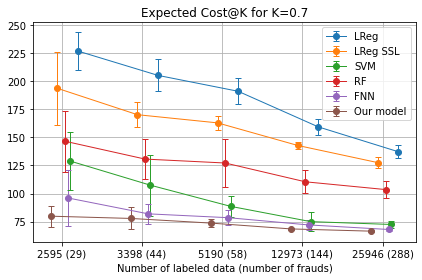

In [ ]:
pl = [1,2,3,4,5,6]
cols = [1,2,4,5,6,7]
jitter = np.random.uniform(-.2, .2, size=len(cols)) 
for j,column in enumerate(cost_mean.columns[cols]):  
    i=0

    plt.errorbar(
        pl[1:] + jitter[j],      # Use the index of the DataFrame as the x-axis
        cost_mean[column].iloc[1:],    # Data for the y-axis from df1
        yerr=cost_sds[column].iloc[1:],  # Error data from df2
        label=column,   # Column name for the legend
        capsize=3,      # Caps on the error bars
        marker='o',     # Marker for the points on the line
        linestyle='-',  # Line style
        linewidth=1     # Line width

    )
    i=i+1
plt.xticks(pl[1:], mean_rs.index.astype(int)[1:])
plt.xticks(pl[1:], ["2595 (29)", "3398 (44)","5190 (58)","12973 (144)","25946 (288)"])
plt.xlabel('Number of labeled data (number of frauds)')
plt.legend(loc="upper right")
plt.grid(True)
plt.title("Expected Cost@K for K=0.7")
plt.tight_layout()
plt.show()

In [ ]:
# save global metric results
#path = "/Users/davidhirnschall/Documents/Uni/SBGAN_results/new_results" + "/orig_ohne_merchant_amount_scaled"
ff = ""
save_results(results_rs, path, "results_rs"+ff)
save_results(mf1_rs, path, "mf1_rs"+ff)
save_results(misclass_df_rs, path, "misclass_df_rs"+ff)
save_results(cross_entropy_df_rs, path, "cross_entropy_df_rs"+ff)
save_results(wauc_df_rs, path, "wauc_df_rs"+ff)
save_results(pr_auc_df_rs, path, "pr_auc_df_rs"+ff)
save_results(rauc_df_rs, path, "rauc_df_rs"+ff)
save_results(brier_df_rs, path, "brier_df_rs"+ff)

# Load saved files and make plots

In [ ]:
res = pd.read_csv("/results/pr_auc_rs_all.csv")

In [ ]:

np.random.seed(123)  #

df = res.groupby("Unnamed: 0")
mean_rs = df.mean().round(decimals=3)
sd_rs = df.std().round(decimals=3)

mean_rs.set_index("N_l", inplace=True)
pl = [1,2,3,4,5,6]#,6]#,4,5]
cols = [2,5,6,7,9,11]

new_names = dict(zip(mean_rs.columns[cols], ["RF2", "LogReg", "LogReg SSL", "SVM", "FNN", "our model"]))
mean_rs = mean_rs.rename(columns=new_names)
sd_rs = sd_rs.rename(columns=new_names)

mean_rs = mean_rs.iloc[:, [cols[i] for i in [5,0,1,2,3,4,6]]]

jitter = np.random.uniform(-.2, .2, size=len(cols)) 
for j,column in enumerate(mean_rs):  
    i=0

    plt.errorbar(
        pl[1:] + jitter[j],      # Use the index of the DataFrame as the x-axis
        mean_rs[column].iloc[1:],    # Data for the y-axis from df1
        yerr=sd_rs[column].iloc[1:],  # Error data from df2
        label=column,   # Column name for the legend
        capsize=3,      # Caps on the error bars
        marker='o',     # Marker for the points on the line
        linestyle='-',  # Line style
        linewidth=1     # Line width

    )
    i=i+1
plt.xticks(pl[1:], ["2595 (29)", "3398 (44)","5190 (58)","12973 (144)","25946 (288)"])
plt.xlabel('Number of labeled data (number of frauds)')
#plt.title('Line Plots with Error Bars')
plt.legend(loc="lower right")
plt.grid(True)
plt.title("PR-Auc AUC")# (customer-history features)")
plt.tight_layout()
#plt.ylim(0,0.15)
plt.show()

# Uncertainty Quantification

In [638]:
rand = 4
j = 1 #1

X_train, y_train = x_labelled_sig_rs[rand][j].numpy(), labels_rs[rand][j]#.numpy()
X_val, y_val = x_fake_test_labelled_sig_rs[rand][j].numpy(), labels_test_rs[rand][j].numpy()
acts_labelled, acts_test = torch.tensor(acts_labelled_rs[rand][j]), torch.tensor(acts_test_rs[rand][j])
X_train_rf = torch.cat((torch.tensor(X_train), acts_labelled), dim=1).numpy()
X_val_rf = torch.cat((torch.tensor(X_val), acts_test), dim=1).numpy()
    
    
gg_prob = 0
gg_prob_list=[]
scores_list = []
for D in Ds_list_rs[rand][j]:
    gg_prob = torch.softmax(D(torch.tensor(X_val), acts_test)[:,1:], dim=1).detach().numpy()
    p = torch.softmax(D(torch.tensor(X_val), acts_test)[:,1:], dim=1).detach().numpy()
    gg_prob_list.append(p)
    
gg_prob = sum(gg_prob_list[-20:])/len(gg_prob_list[-20:])  # last 5 vs all
stacked = np.stack([p[:,1] for p in gg_prob_list[-20:]], axis=0)
        
gg_prob_u = np.quantile(stacked, q=0.05, axis=0)
gg_prob_o = np.quantile(stacked, q=0.95, axis=0)

In [ ]:
# FP 
np.where((gg_prob_u<0.5) & (gg_prob_o>0.5) & (y_val==0) & (gg_prob[:,1]>0.5))[0]

array([12512, 19756, 22584, 25018, 34803, 37168, 38112, 39403, 43573,
       47790, 49728, 52711])

In [ ]:
# TP
np.where((gg_prob_u<0.5) & (gg_prob_o>0.5) & (y_val==1) & (gg_prob[:,1]>0.5))[0]

array([57187, 57233, 57324, 57361, 57474, 57510, 57605])

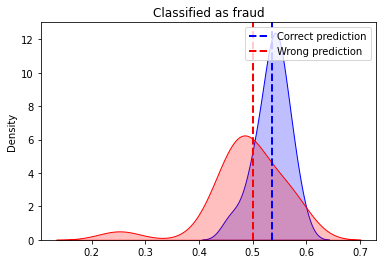

(1, 0.53620493, 0, 0.5004935)

In [ ]:
# plot for transactions classified as fraud
i = 1
t = 57324  
f = 12512   
import seaborn as sns
sns.kdeplot([gg_prob_list[-i][t,1] for i in range(20)], color="blue", shade=True) #true
sns.kdeplot([gg_prob_list[-i][f,1] for i in range(20)], color="red", shade=True) #false
plt.axvline(gg_prob[t,1], color='blue', linestyle='--', linewidth=2, label='Correct prediction')
plt.axvline(gg_prob[f,1], color='red', linestyle='--', linewidth=2, label='Wrong prediction')
plt.legend(loc='upper right')
plt.title("Classified as fraud")
plt.show()

y_val[t], gg_prob[t,1], y_val[f], gg_prob[f,1]

In [ ]:
# FN
np.where((gg_prob_u<0.5) & (gg_prob_o>0.5) & (y_val==1) & (gg_prob[:,1]<0.5))[0]

array([57018, 57054, 57099, 57130, 57160, 57222, 57232, 57355, 57582,
       57625])

In [ ]:
# TN
np.where((gg_prob_u<0.5) & (gg_prob_o>0.5) & (y_val==0) & (gg_prob[:,1]<0.5))[0]

array([11772, 16104, 19337, 25118, 35840, 37527, 43070, 53135])

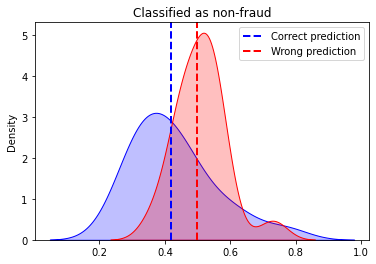

(0, 0.4181249, 1, 0.49898323)

In [ ]:
# plot for transactions classified as fraud
i = 1
t = 35840 
f = 57232   
import seaborn as sns
sns.kdeplot([gg_prob_list[-i][t,1] for i in range(20)], color="blue", shade=True, clip=(0, 1)) #true
sns.kdeplot([gg_prob_list[-i][f,1] for i in range(20)], color="red", shade=True, clip=(0, 1)) #false
plt.axvline(gg_prob[t,1], color='blue', linestyle='--', linewidth=2, label='Correct prediction')
plt.axvline(gg_prob[f,1], color='red', linestyle='--', linewidth=2, label='Wrong prediction')
plt.legend(loc='upper right')
plt.title("Classified as non-fraud")
plt.show()

y_val[t], gg_prob[t,1], y_val[f], gg_prob[f,1]

In [ ]:
#auroc for uncertainty/misclassification
for k in range(6):
    print(k)
    all_fp, all_fn, all_tp, all_tn, auroc = [],[],[],[],[]
    for rand in range(len(random_state)):
        
        X_train, y_train = x_labelled_sig_rs[rand][k].numpy(), labels_rs[rand][k]#.numpy()
        acts_labelled, acts_test = torch.tensor(acts_labelled_rs[rand][k]), torch.tensor(acts_test_rs[rand][k])    
        X_val, y_val = x_fake_test_labelled_sig_rs[rand][k].numpy(), labels_test_rs[rand][k].numpy()
            
        gg_prob_list=[]
        for D in Ds_list_rs[rand][k]:
            p = torch.softmax(D(torch.tensor(X_val), acts_test)[:,1:], dim=1).detach().numpy()
            gg_prob_list.append(p)
            
        gg_prob = sum(gg_prob_list[-20:])/len(gg_prob_list[-20:])
        stacked = np.stack([p[:,1] for p in gg_prob_list[-20:]], axis=0)
        gg_prob_u = np.quantile(stacked, q=0.05, axis=0)
        gg_prob_o = np.quantile(stacked, q=0.95, axis=0)
        
        scores_np = np.array(stacked.std(axis=0))
        error_np = np.array( (gg_prob[:,1]>=0.5) & (y_val == 0) | (gg_prob[:,1]<0.5) & (y_val == 1) )
        auroc.append(roc_auc_score(error_np.flatten(), scores_np.flatten()))
        
    print("AUROC: ", np.mean(auroc), np.std(auroc))
    

0
AUROC:  0.8240658369965004 0.06349189648483984
1
AUROC:  0.8730458552241329 0.03265067109135825
2
AUROC:  0.9009530189400765 0.007571910264767709
3
AUROC:  0.9131710358321083 0.0061575128858873
4
AUROC:  0.9307093351251614 0.0059841437284753754
5
AUROC:  0.9345042249260015 0.00630525262102302


In [ ]:
# uncertainty interval lengths
k=0 #4
for k in range(6):
    print(k)
    all_fp, all_fn, all_tp, all_tn = [],[],[],[]
    for rand in range(len(random_state)):
        
        X_train, y_train = x_labelled_sig_rs[rand][k].numpy(), labels_rs[rand][k]#.numpy()
        acts_labelled, acts_test = torch.tensor(acts_labelled_rs[rand][k]), torch.tensor(acts_test_rs[rand][k])    
        X_val, y_val = x_fake_test_labelled_sig_rs[rand][k].numpy(), labels_test_rs[rand][k].numpy()
        
            
        gg_prob_list=[]
        for D in Ds_list_rs[rand][k]:
            p = torch.softmax(D(torch.tensor(X_val), acts_test)[:,1:], dim=1).detach().numpy()
            gg_prob_list.append(p)
            
        gg_prob = sum(gg_prob_list[-20:])/len(gg_prob_list[-20:])
        stacked = np.stack([p[:,1] for p in gg_prob_list[-20:]], axis=0)
        #gg_prob = np.quantile(np.stack([p for p in gg_prob_list], axis=0), q=0.5, axis=0)
        gg_prob_u = np.quantile(stacked, q=0.05, axis=0)
        gg_prob_o = np.quantile(stacked, q=0.95, axis=0)
        
        fp = np.where((gg_prob[:,1]>=0.5) & (y_val == 0))[0] #FP
        all_fp.append([gg_prob_o[j] - gg_prob_u[j] for j in fp])

        fn = np.where((gg_prob[:,1]<0.5) & (y_val == 1))[0] #FN
        all_fn.append([gg_prob_o[j] - gg_prob_u[j] for j in fn])

        tp = np.where((gg_prob[:,1]>=0.5) & (y_val == 1))[0] #TP
        all_tp.append([gg_prob_o[j] - gg_prob_u[j] for j in tp])
        
        tn = np.where((gg_prob[:,1]<0.5) & (y_val == 0))[0] #TN
        all_tn.append([gg_prob_o[j] - gg_prob_u[j] for j in tn])

    print("TP: ", np.mean([item for sublist in all_tp for item in sublist]).round(4), np.std([item for sublist in all_tp for item in sublist]).round(4))
    print("TN: ", np.mean([item for sublist in all_tn for item in sublist]).round(4), np.std([item for sublist in all_tn for item in sublist]).round(4))
    print("FP: ", np.mean([item for sublist in all_fp for item in sublist]).round(4), np.std([item for sublist in all_fp for item in sublist]).round(4))
    print("FN: ", np.mean([item for sublist in all_fn for item in sublist]).round(4), np.std([item for sublist in all_fn for item in sublist]).round(4))



0
TP:  0.0362 0.068
TN:  0.0011 0.0116
FP:  0.0792 0.0875
FN:  0.0252 0.0652
1
TP:  0.0176 0.0331
TN:  0.0007 0.0052
FP:  0.0574 0.0499
FN:  0.0233 0.0366
2
TP:  0.0309 0.0593
TN:  0.0009 0.0059
FP:  0.0552 0.0553
FN:  0.0315 0.0529
3
TP:  0.0217 0.0403
TN:  0.0008 0.006
FP:  0.0448 0.0459
FN:  0.028 0.0518
4
TP:  0.0101 0.0151
TN:  0.0004 0.0025
FP:  0.0281 0.0263
FN:  0.015 0.021
5
TP:  0.0088 0.0122
TN:  0.0004 0.0022
FP:  0.0234 0.019
FN:  0.0146 0.0197


In [ ]:
#barchart for expected cost@0.5
import matplotlib.pyplot as plt
import numpy as np

# Data from the table (excluding AUROC)
Nl = [2595, 3893, 5190, 12973, 25946]
TP = [0.0176, 0.0309, 0.0217, 0.0101, 0.0088]
FP = [0.0574, 0.0552, 0.0448, 0.0281, 0.0234]
TN = [0.0007, 0.0009, 0.0008, 0.0004, 0.0004]
FN = [0.0233, 0.0315, 0.0280, 0.0150, 0.0146]

# Grouped bar chart
bar_width = 0.2
x = np.arange(len(Nl))

plt.bar(x - 1.5*bar_width, TP, width=bar_width, label='TP')
plt.bar(x - 0.5*bar_width, FP, width=bar_width, label='FP')
plt.bar(x + 0.5*bar_width, TN, width=bar_width, label='TN')
plt.bar(x + 1.5*bar_width, FN, width=bar_width, label='FN')

plt.xticks(x, Nl)
plt.xlabel("Sample Size $N_l$")
plt.ylabel("Average Interval Length")
plt.title("Uncertainty Interval Lengths by Category")
plt.legend()
plt.tight_layout()
plt.savefig("/results/interval_widths.png", format="png", dpi=300)
plt.show()